In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Does Timp3 utilize differential 3' UTRs in other samples?

ReadZs has been run on Tabula sapiens in window-mode, but from the counts files we can test if Timp3 utilizes differential 3' UTRs in these samples

More detail in README in /oak/stanford/groups/horence/rob/isoform_localizations/SRRS/analysis/tabula_sapiens_timp3_readzs along with intermediate and final outputs

Timp3 is a positive strand gene in humans but overlaps with Syn3, a negative strand gene

In [2]:
meta_df = pd.read_csv(
    '/oak/stanford/groups/horence/Roozbeh/single_cell_project/utility_files/meta_data/Tabula_Sapiens/TSP1_TSP15_scvi_donor-method_normalized-log1p-scaled_annotated.csv',
)

meta_df['tissue'] = meta_df['tissue'].str.lower()

meta_df.head()

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (1,2,4,8,9,11,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cell_id,10X_run,pilot,tissue,subtissue,method,10X_sample,10X_replicate,notes,seqrun,...,score_endothelial,score_stromal,score_immune,computational_compartment_assignment,tissue_cell_type,cell_type_tissue,cell_ontology_class,free_annotation,manually_annotated,compartment
0,AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1,TSP6_Liver_NA_10X_1_1,TSP6,liver,NaN,10X,1.0,1.0,NaN,5,...,-0.204963,-0.361502,0.289220,immune,Liver_macrophage,macrophage_Liver,macrophage,Monocyte/Macrophage,True,immune
1,AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1,TSP6_Liver_NA_10X_1_1,TSP6,liver,NaN,10X,1.0,1.0,NaN,5,...,-0.014423,-0.191972,1.151659,immune,Liver_monocyte,monocyte_Liver,monocyte,Monocyte,True,immune
2,AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1,TSP6_Liver_NA_10X_1_1,TSP6,liver,NaN,10X,1.0,1.0,NaN,5,...,1.702599,-0.046488,-1.167351,endothelial,Liver_endothelial cell,endothelial cell_Liver,endothelial cell of hepatic sinusoid,Endothelial,True,endothelial
3,AAAGAACAGCCTCTTC_TSP6_Liver_NA_10X_1_1,TSP6_Liver_NA_10X_1_1,TSP6,liver,NaN,10X,1.0,1.0,NaN,5,...,-0.310947,-0.437353,0.664461,immune,Liver_macrophage,macrophage_Liver,macrophage,Monocyte/Macrophage,True,immune
4,AAAGAACGTAGCACAG_TSP6_Liver_NA_10X_1_1,TSP6_Liver_NA_10X_1_1,TSP6,liver,NaN,10X,1.0,1.0,NaN,5,...,-0.223558,-0.285408,0.020373,immune,Liver_dendritic cell,dendritic cell_Liver,liver dendritic cell,Dendritic cell,True,immune


In [12]:
meta_df[meta_df['tissue'].eq('heart')]['method'].value_counts(dropna=False)

10X          11228
smartseq2      277
Name: method, dtype: int64

In [ ]:
#The meta_df does not have consistent formatting
#TSP2 and TSP1 10X_barcodes are concatenated with more info
corrected_meta_df = pd.DataFrame()

for donor_method,g in meta_df.groupby('donor_method'):
    if 'smartseq2' in donor_method:
        continue
    
    if donor_method in ['TSP110X','TSP210X']:
        g['10X_barcode'] = g['10X_barcode'].str.split('_').str[0]
    
    #print(donor_method,'has',g.shape[0],'rows')
    #print('dropping {} rows without 10X barcodes'.format(g['10X_barcode'].isnull().sum()))
    #g = g.dropna(subset=['10X_barcode'])
    #print('Unique lengths of 10X barcodes',g['10X_barcode'].str.len().unique())
    #print('')
    
    g['pilot'] = g['donor_method'].str[:-3]
    
    corrected_meta_df = pd.concat((corrected_meta_df, g[[
        'pilot','10X_barcode','tissue',
        'compartment','consensus_prediction',
    ]]))
    
    
corrected_meta_df.head()

In [4]:
corrected_meta_df['pilot'].unique()

array(['TSP10', 'TSP1', 'TSP11', 'TSP12', 'TSP14', 'TSP15', 'TSP2',
       'TSP3', 'TSP4', 'TSP5', 'TSP6', 'TSP7', 'TSP8', 'TSP9'],
      dtype=object)

In [9]:
timp3_counts_df = pd.read_csv(
    '/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/analysis/tabula_sapiens_timp3_readzs/timp3_counts.tsv',
    sep = '\t',
    header = None,
    names = ['file_name:extended_cell_id','chr','pos','strand','count','sample','window'],
)

split_fn_id = timp3_counts_df['file_name:extended_cell_id'].str.split(':').str
timp3_counts_df['file_name'] = split_fn_id[0]
timp3_counts_df['extended_cell_id'] = split_fn_id[1]
timp3_counts_df = timp3_counts_df.drop(columns = ['file_name:extended_cell_id'])

split_cell_id = timp3_counts_df['extended_cell_id'].str.split('_').str
timp3_counts_df['pilot'] = split_cell_id[0]
timp3_counts_df['tissue'] = split_cell_id[1]
timp3_counts_df['10X_barcode'] = split_cell_id[-1]
timp3_counts_df['tissue'] = timp3_counts_df['tissue'].str.lower()

timp3_counts_df

,chr,pos,strand,count,sample,window,file_name,extended_cell_id,pilot,tissue,10X_barcode
0,chr22,32855597,-,1,TSP1_bladder_1_S7,chr22_6572_minus,/oak/stanford/groups/horence/Roozbeh/single_ce...,TSP1_bladder_1_S7_CTCCAACCATTCACCC,TSP1,bladder,CTCCAACCATTCACCC
1,chr22,32857516,-,1,TSP1_bladder_1_S7,chr22_6572_minus,/oak/stanford/groups/horence/Roozbeh/single_ce...,TSP1_bladder_1_S7_TCCTCGATCTGCATGA,TSP1,bladder,TCCTCGATCTGCATGA
2,chr22,32859207,-,1,TSP1_bladder_1_S7,chr22_6572_minus,/oak/stanford/groups/horence/Roozbeh/single_ce...,TSP1_bladder_1_S7_TTCACCAAGATGCCCC,TSP1,bladder,TTCACCAAGATGCCCC
3,chr22,32859222,-,1,TSP1_bladder_1_S7,chr22_6572_minus,/oak/stanford/groups/horence/Roozbeh/single_ce...,TSP1_bladder_1_S7_AAGCAGATGAAGATGT,TSP1,bladder,AAGCAGATGAAGATGT
4,chr22,32859240,-,1,TSP1_bladder_1_S7,chr22_6572_minus,/oak/stanford/groups/horence/Roozbeh/single_ce...,TSP1_bladder_1_S7_AGCTGGTAAAGGAGGG,TSP1,bladder,AGCTGGTAAAGGAGGG
...,...,...,...,...,...,...,...,...,...,...,...
908121,chr22,32862952,+,1,TSP2_Vasculature_Aorta_10X_1_1_S26,chr22_6573_plus,/oak/stanford/groups/horence/Roozbeh/single_ce...,TSP2_Vasculature_Aorta_10X_1_1_S26_GGTTGTATCGT...,TSP2,vasculature,GGTTGTATCGTCTAAG
908122,chr22,32862952,+,1,TSP2_Vasculature_Aorta_10X_1_1_S26,chr22_6573_plus,/oak/stanford/groups/horence/Roozbeh/single_ce...,TSP2_Vasculature_Aorta_10X_1_1_S26_TGGTGATCAAC...,TSP2,vasculature,TGGTGATCAACACTAC
908123,chr22,32862953,+,1,TSP2_Vasculature_Aorta_10X_1_1_S26,chr22_6573_plus,/oak/stanford/groups/horence/Roozbeh/single_ce...,TSP2_Vasculature_Aorta_10X_1_1_S26_ATGACCATCCG...,TSP2,vasculature,ATGACCATCCGAAGGA
908124,chr22,32864178,+,1,TSP2_Vasculature_Aorta_10X_1_1_S26,chr22_6573_plus,/oak/stanford/groups/horence/Roozbeh/single_ce...,TSP2_Vasculature_Aorta_10X_1_1_S26_CTAAGTGGTTT...,TSP2,vasculature,CTAAGTGGTTTGGGTT


In [10]:
timp3_counts_df['pilot'].value_counts()

TSP2     590198
TSP14    219818
TSP1      98110
Name: pilot, dtype: int64

In [11]:
corrected_meta_df[corrected_meta_df['pilot'].eq('TSP14')]['tissue']

157804          blood
157805          blood
157806          blood
157807          blood
157808          blood
             ...     
346824    vasculature
346825    vasculature
346826    vasculature
346827    vasculature
346828    vasculature
Name: tissue, Length: 183374, dtype: object

In [14]:
#Merge the ontology info
merge_cols = ['pilot','tissue','10X_barcode']

m = timp3_counts_df.merge(
    corrected_meta_df, 
    on = merge_cols,
)

m.head()

,chr,pos,strand,count,sample,window,file_name,extended_cell_id,pilot,tissue,10X_barcode,compartment,consensus_prediction
0,chr22,32855597,-,1,TSP1_bladder_1_S7,chr22_6572_minus,/oak/stanford/groups/horence/Roozbeh/single_ce...,TSP1_bladder_1_S7_CTCCAACCATTCACCC,TSP1,bladder,CTCCAACCATTCACCC,epithelial,bladder urothelial cell
1,chr22,32859594,-,1,TSP1_bladder_1_S7,chr22_6572_minus,/oak/stanford/groups/horence/Roozbeh/single_ce...,TSP1_bladder_1_S7_CTCCAACCATTCACCC,TSP1,bladder,CTCCAACCATTCACCC,epithelial,bladder urothelial cell
2,chr22,32861046,-,1,TSP1_bladder_1_S7,chr22_6573_minus,/oak/stanford/groups/horence/Roozbeh/single_ce...,TSP1_bladder_1_S7_CTCCAACCATTCACCC,TSP1,bladder,CTCCAACCATTCACCC,epithelial,bladder urothelial cell
3,chr22,32857489,+,1,TSP1_bladder_1_S7,chr22_6572_plus,/oak/stanford/groups/horence/Roozbeh/single_ce...,TSP1_bladder_1_S7_CTCCAACCATTCACCC,TSP1,bladder,CTCCAACCATTCACCC,epithelial,bladder urothelial cell
4,chr22,32858011,+,1,TSP1_bladder_1_S7,chr22_6572_plus,/oak/stanford/groups/horence/Roozbeh/single_ce...,TSP1_bladder_1_S7_CTCCAACCATTCACCC,TSP1,bladder,CTCCAACCATTCACCC,epithelial,bladder urothelial cell


In [15]:
m.dropna().to_csv('timp3_10X_annotated_counts.csv',index=False)

In [41]:
#Aggregating counts per sample/ontology/position/strand and binning into 10-bp bins
m['binned_pos'] = (m['pos']//10)*10

agg_timp3 = m.groupby(
    ['pilot','tissue','compartment','consensus_prediction','binned_pos','strand']
)['count'].sum().reset_index()

agg_timp3 = agg_timp3.rename(columns={'binned_pos':'pos'})

print(timp3_counts_df.shape)
print(agg_timp3.shape)

(908126, 11)
(36358, 7)


In [42]:
agg_timp3.head()

,pilot,tissue,compartment,consensus_prediction,pos,strand,count
0,TSP1,bladder,endothelial,capillary endothelial cell,32855770,+,1
1,TSP1,bladder,endothelial,capillary endothelial cell,32857380,+,1
2,TSP1,bladder,endothelial,capillary endothelial cell,32857420,+,1
3,TSP1,bladder,endothelial,capillary endothelial cell,32857520,+,1
4,TSP1,bladder,endothelial,capillary endothelial cell,32858030,+,1


In [43]:
agg_timp3['pos'].min()

32855000

In [44]:
agg_timp3['pos'].max()

32864990

In [45]:
agg_timp3.groupby('strand')['count'].sum()

strand
+    705223
-     58982
Name: count, dtype: int64

In [46]:
agg_timp3.to_csv('sample_ont_pos_timp3_counts_binned.csv',index=False)

In [47]:
agg_timp3['consensus_prediction'].value_counts()

fibroblast                                              4033
capillary endothelial cell                              3591
pericyte cell                                           2714
vein endothelial cell                                   2617
endothelial cell of artery                              2282
macrophage                                              1879
vascular associated smooth muscle cell                  1630
mesenchymal stem cell                                   1286
endothelial cell of lymphatic vessel                    1138
endothelial cell                                        1128
myofibroblast cell                                      1108
type i pneumocyte                                       1010
type ii pneumocyte                                       925
bladder urothelial cell                                  912
basal cell                                               850
endothelial cell of vascular tree                        795
alveolar fibroblast     

In [48]:
data = {
    'tissue':[],
    'ont':[],
    'pos':[],
    'strand':[],
}
for i,r in agg_timp3.iterrows():
    data['tissue'].extend([r['tissue']]*r['count'])
    data['ont'].extend([r['consensus_prediction']]*r['count'])
    data['pos'].extend([r['pos']]*r['count'])
    data['strand'].extend([r['strand']]*r['count'])
    
    
long_agg_df = pd.DataFrame(data)
long_agg_df.head()

,tissue,ont,pos,strand
0,bladder,capillary endothelial cell,32855770,+
1,bladder,capillary endothelial cell,32857380,+
2,bladder,capillary endothelial cell,32857420,+
3,bladder,capillary endothelial cell,32857520,+
4,bladder,capillary endothelial cell,32858030,+


In [49]:
print(long_agg_df.shape)
print(agg_timp3['count'].sum())

(764205, 4)
764205


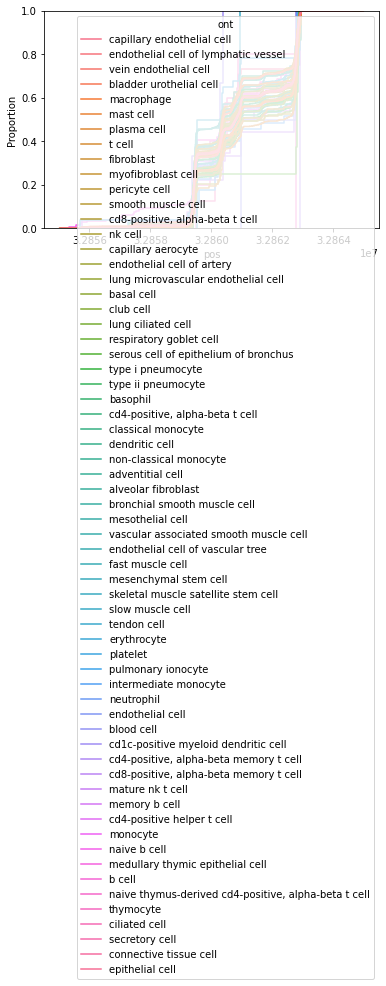

In [53]:
sns.ecdfplot(
    x = 'pos',
    hue = 'ont',
    data = long_agg_df[long_agg_df['strand'].eq('+')],
)
plt.show()
plt.close()

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import collections

pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_rows = 100
from statsmodels.stats import multitest
from scipy import stats

import pysam
import time
import glob
import re
import os

In [7]:
def plot_read_buildup_3UTR(gene,ann,ax,scale_bar_size=5000):

    gene_gtf = ann[ann['gene_name'].eq(gene)]
    chrom = gene_gtf['chrom'].unique()[0]
    strand = 'plus' if gene_gtf['strand'].unique()[0] == '+' else 'minus'

    xmin,ymin,xmax,ymax = None,0,None,None

    for i,(transcript_id,transcript_df) in enumerate(gene_gtf.groupby('transcript_id')):
        y = 2*(i+1)
        #Draw a line for the intro from the total start to total end
        min_x_transcript = transcript_df['start'].min()
        max_x_transcript = transcript_df['stop'].max()

        intron_line = Rectangle(
            (min_x_transcript, y - 0.1),
            max_x_transcript - min_x_transcript, 0.2,
            linewidth=1,edgecolor='k',facecolor='k',
        )
        ax.add_patch(intron_line)

        prev_5UTR = False
        prev_3UTR = False
        for _,feature in transcript_df.iterrows():
            #NOTE!! JUST PRINTING 3' UTR
            if feature['kind'] != '3UTR':
                continue
            
            height = 1
            #Sometimes there are multiple 5' and 3' UTRs for a single transcript??? just using the first
            if prev_3UTR:
                continue
            prev_3UTR = True
            height = 0.5

            ymax = y+1

            x = feature['start']
            xmin = min(xmin,x) if xmin else x

            width = feature['stop']-feature['start']
            xmax = max(xmax,feature['stop']) if xmax else feature['stop']

            rect = Rectangle(
                (x, y - height/2),
                width, height,
                linewidth=0.5,edgecolor='k',facecolor='white',
            )
            ax.add_patch(rect)

    gene_width = xmax-xmin
    view_width = 1.1*gene_width
    offset = (view_width-gene_width)/2

    scale = Rectangle(
        (xmin-offset, -0.5),
        scale_bar_size, 1,
        linewidth=0.5,edgecolor='k',facecolor='blue',
    )
    ax.add_patch(scale)

    ax.set_xlim(xmin-offset,xmax+offset)
    ax.set_ylim(-1,ymax)
    ax.axis('off')


hg_timp3_gtf = pd.read_csv('/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/analysis/tabula_sapiens_timp3_readzs/hg38_timp3.gtf')





In [ ]:
# Slow large plot
fig,axs = plt.subplots(
    figsize=(10,5),
    nrows = 3, ncols = 1,
    sharex = True,
    gridspec_kw={'height_ratios': [1, 2, 2]},
)

plot_read_buildup_3UTR(
    'Timp3',hg_timp3_gtf,ax=axs[0],scale_bar_size=1000,
)
print('Created 3 UTR diagram')

#Filter to only include genes with 
onts = (
    m.groupby('consensus_prediction').filter(
        lambda g: g['count'].sum() > 1000
    )['consensus_prediction'].unique()
)

plot_df = long_agg_df[
    long_agg_df['strand'].eq('+') &
    long_agg_df['ont'].isin(onts)
]

sns.ecdfplot(
    x = 'pos',
    hue = 'ont',
    data = plot_df,
    ax = axs[1],
)
sns.move_legend(axs[1], "upper left", bbox_to_anchor=(1, 1))
print('Created eCDF')

sns.lineplot(
    x = 'pos',
    y = 'count',
    hue = 'consensus_prediction',
    legend = False,
    data = agg_timp3[agg_timp3['consensus_prediction'].isin(onts)],
    ax = axs[2],
)
print('Created lineplot')

plt.suptitle("Human Timp3 3' UTR Tabula sapiens read buildup")
plt.show()
plt.close()

In [62]:
g

,tissue,ont,pos,strand
0,bladder,capillary endothelial cell,32855770,+
1,bladder,capillary endothelial cell,32857380,+
2,bladder,capillary endothelial cell,32857420,+
3,bladder,capillary endothelial cell,32857520,+
4,bladder,capillary endothelial cell,32858030,+
...,...,...,...,...
257195,bladder,smooth muscle cell,32862900,+
257196,bladder,smooth muscle cell,32862900,+
257197,bladder,smooth muscle cell,32862900,+
257198,bladder,smooth muscle cell,32862910,+


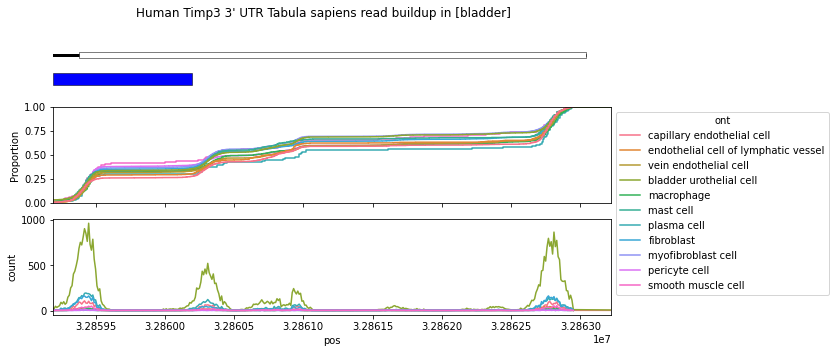

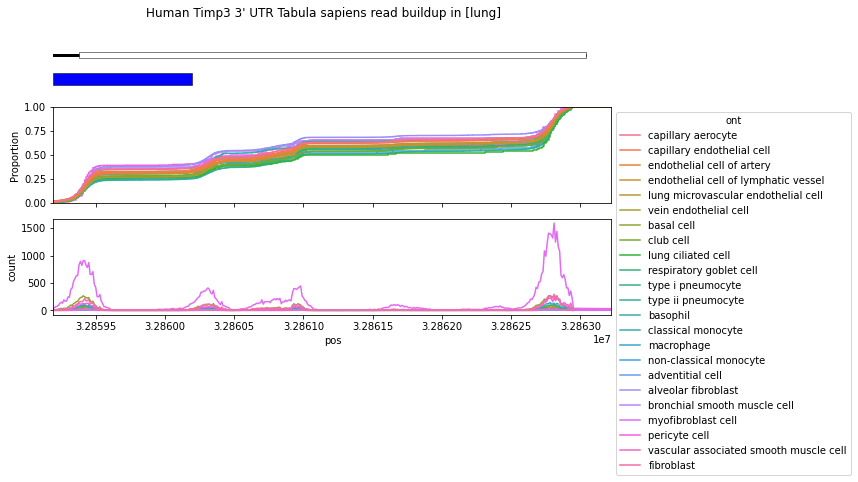

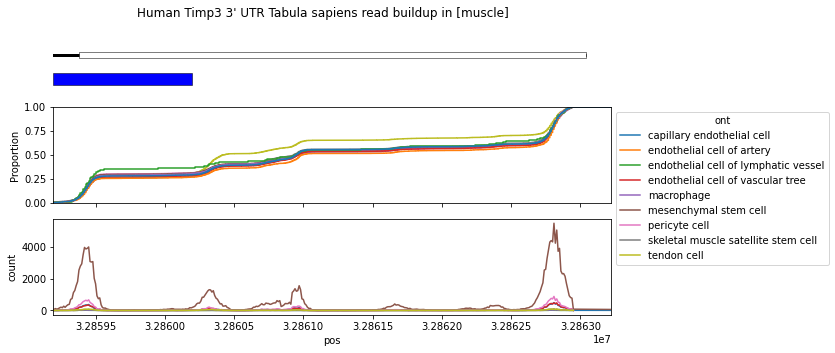

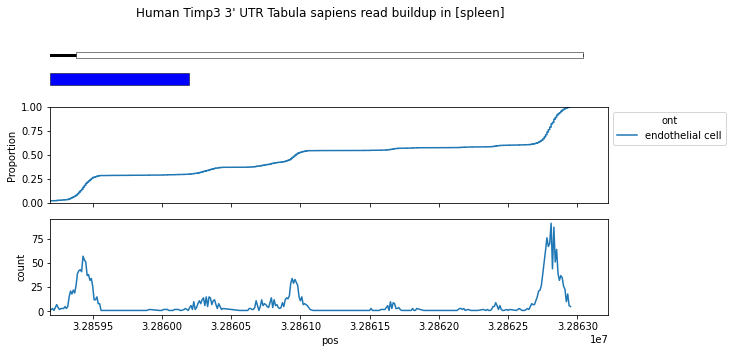

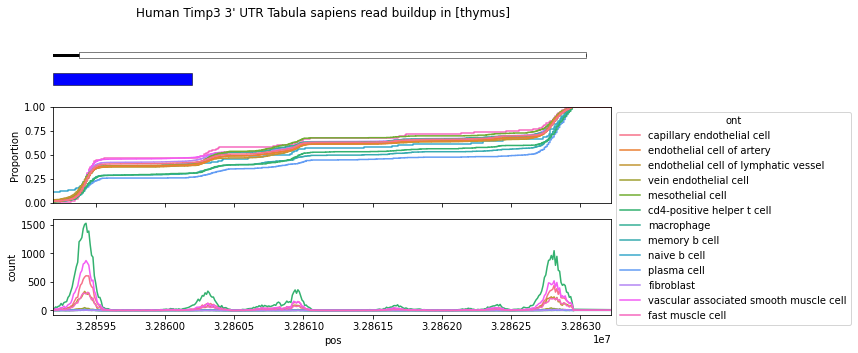

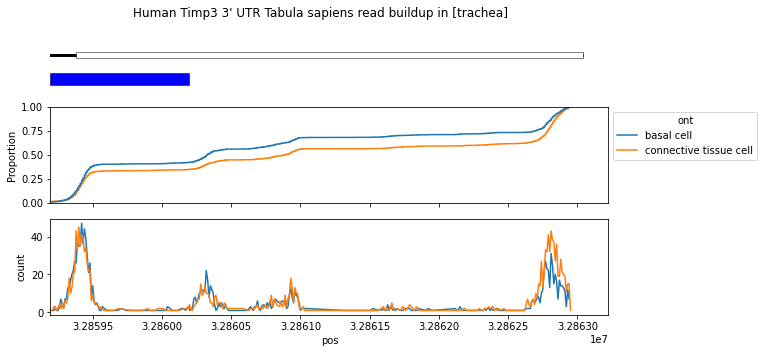

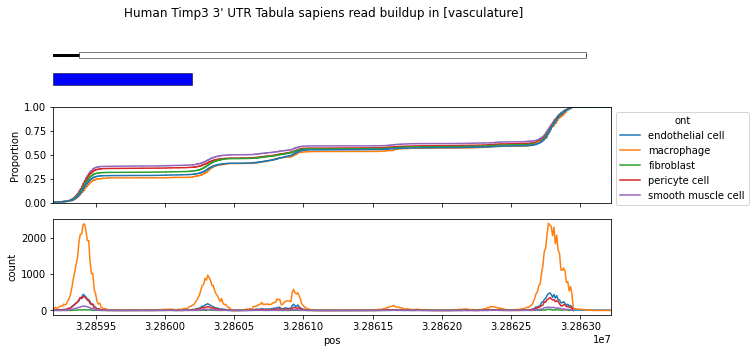

In [77]:
for tissue,g in long_agg_df.groupby('tissue'):
    
    g = g[g['strand'].eq('+')] #Timp3 is on the plus strand
    
    #Filter to only include genes with a certain threshold of counts
    g = g.groupby('ont').filter(lambda g: len(g) > 100)
    if not len(g):
        continue
    
    fig,axs = plt.subplots(
        figsize=(10,5),
        nrows = 3, ncols = 1,
        sharex = True,
        gridspec_kw={'height_ratios': [1, 2, 2]},
    )

    plot_read_buildup_3UTR(
        'Timp3',hg_timp3_gtf,ax=axs[0],scale_bar_size=1000,
    )
    
    sns.ecdfplot(
        x = 'pos',
        hue = 'ont',
        data = g,
        ax = axs[1],
    )
    sns.move_legend(axs[1], "upper left", bbox_to_anchor=(1, 1))

    agg_g = g.groupby(['ont','pos']).size().reset_index(name='count')
    sns.lineplot(
        x = 'pos',
        y = 'count',
        hue = 'ont',
        legend = False,
        data = agg_g,
        ax = axs[2],
    )

    plt.suptitle("Human Timp3 3' UTR Tabula sapiens read buildup in [{}]".format(tissue))
    plt.show()
    plt.close()

In [35]:
m['pilot'].unique()

array(['TSP1'], dtype=object)

In [28]:
(
    m.groupby(
        ['consensus_prediction']
    ).agg(
        num_10X_cells = ('10X_barcode','nunique'),
        num_tot_reads = ('count','sum'),
    ).sort_values(
        'num_tot_reads',
        ascending=False,
    )
).reset_index()

,consensus_prediction,num_10X_cells,num_tot_reads
0,fibroblast,8501,203234
1,mesenchymal stem cell,7801,201112
2,type i pneumocyte,3053,63985
3,capillary endothelial cell,3145,56365
4,pericyte cell,2164,50819
5,vascular associated smooth muscle cell,1093,30736
6,vein endothelial cell,1624,26160
7,endothelial cell,1258,21409
8,endothelial cell of artery,776,19912
9,endothelial cell of vascular tree,2378,17234


In [29]:
(
    m.groupby(
        ['pilot','tissue','compartment','consensus_prediction']
    ).agg(
        num_10X_cells = ('10X_barcode','nunique'),
        num_tot_reads = ('count','sum'),
    ).sort_values(
        'num_tot_reads',
        ascending=False,
    )
).reset_index()

,pilot,tissue,compartment,consensus_prediction,num_10X_cells,num_tot_reads
0,TSP2,muscle,stromal,mesenchymal stem cell,7071,190045
1,TSP2,vasculature,stromal,fibroblast,2364,100254
2,TSP14,lung,epithelial,type i pneumocyte,2803,61599
3,TSP14,thymus,stromal,fibroblast,1093,29383
4,TSP2,thymus,stromal,fibroblast,574,28956
...,...,...,...,...,...,...
247,TSP2,spleen,immune,nk cell,1,1
248,TSP2,spleen,immune,"naive thymus-derived cd4-positive, alpha-beta ...",1,1
249,TSP2,muscle,immune,erythrocyte,1,1
250,TSP2,muscle,stromal,fast muscle cell,1,1


# Making bedGraphs for browser plotting

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('timp3_10X_annotated_counts.csv')
df = df[df['strand'].eq('+')] #Timp3 is on the plus strand
df.head()

,chr,pos,strand,count,sample,window,file_name,extended_cell_id,pilot,tissue,10X_barcode,compartment,consensus_prediction
3,chr22,32857489,+,1,TSP1_bladder_1_S7,chr22_6572_plus,/oak/stanford/groups/horence/Roozbeh/single_ce...,TSP1_bladder_1_S7_CTCCAACCATTCACCC,TSP1,bladder,CTCCAACCATTCACCC,epithelial,bladder urothelial cell
4,chr22,32858011,+,1,TSP1_bladder_1_S7,chr22_6572_plus,/oak/stanford/groups/horence/Roozbeh/single_ce...,TSP1_bladder_1_S7_CTCCAACCATTCACCC,TSP1,bladder,CTCCAACCATTCACCC,epithelial,bladder urothelial cell
5,chr22,32855817,+,1,TSP1_bladder_1_S7,chr22_6572_plus,/oak/stanford/groups/horence/Roozbeh/single_ce...,TSP1_bladder_1_S7_CTCCAACCATTCACCC,TSP1,bladder,CTCCAACCATTCACCC,epithelial,bladder urothelial cell
6,chr22,32862735,+,1,TSP1_bladder_1_S7,chr22_6573_plus,/oak/stanford/groups/horence/Roozbeh/single_ce...,TSP1_bladder_1_S7_CTCCAACCATTCACCC,TSP1,bladder,CTCCAACCATTCACCC,epithelial,bladder urothelial cell
8,chr22,32860869,+,1,TSP1_bladder_1_S7,chr22_6573_plus,/oak/stanford/groups/horence/Roozbeh/single_ce...,TSP1_bladder_1_S7_TCCTCGATCTGCATGA,TSP1,bladder,TCCTCGATCTGCATGA,stromal,myofibroblast cell


In [ ]:
#This is what a BedGraph needs to look like (without all the #'s)
#track type=bedGraph name="BedGraph Format" description="BedGraph format" visibility=full color=200,100,0 altColor=0,100,200 priority=20
#chr19 49302000 49302300 -1.0
#chr19 49302300 49302600 -0.75
#chr19 49302600 49302900 -0.50

In [10]:
bin_size = 10

#hardcoding Timp3 3' UTR
chrom = 'chr22'
min_val = 32859048
max_val = 32863111

df = df[df['pos'].between(min_val,max_val)]
df = df.groupby(['tissue','consensus_prediction']).filter(lambda g: g['count'].sum() >= 100)

bins = np.arange(min_val,max_val,bin_size)
bin_labels = pd.Categorical(bins[:-1])

df['bin'] = pd.cut(df['pos'], bins=bins)

for tissue,tissue_g in df.groupby('tissue'):
    num_onts = tissue_g['consensus_prediction'].nunique()
    colors = sns.color_palette('viridis',num_onts)
    
    for i,(ont,g) in enumerate(tissue_g.groupby('consensus_prediction')):
        
        red,green,blue = colors[i]
        red,green,blue = int(256*red),int(256*green),int(256*blue)

        tot_counts = g['count'].sum()

        bin_counts = g.groupby(['chr','bin'])['count'].sum().fillna(0)
        norm_bin_counts = bin_counts#/bin_counts.max()
        cs_counts = bin_counts.cumsum()/tot_counts

        #Write out the cumulative table
        cs_out_path = 'bedGraphs/{}_{}.bedGraph'.format(tissue,ont).replace(' ','_')
        
        with open(cs_out_path,'w') as f_out:
            f_out.write('browser position {}:{}-{}\n'.format(chrom,min_val,max_val))
            f_out.write('track type=bedGraph name="cs {}" visibility=hide maxHeightPixels=50 graphType=points\n'.format(ont))

        cs_df = cs_counts.reset_index()
        cs_df['left'] = cs_df['bin'].apply(lambda v: v.left)
        cs_df['right'] = cs_df['bin'].apply(lambda v: v.right)
        cs_df[['chr','left','right','count']].to_csv(cs_out_path, mode='a', header=None, sep=' ', index=None)

        #Write out the density table
        density_out_path = 'bedGraphs/density_{}_{}.bedGraph'.format(tissue,ont).replace(' ','_')

        with open(density_out_path,'w') as f_out:
            f_out.write('browser position {}:{}-{}\n'.format(chrom,min_val,max_val))
            f_out.write('track type=bedGraph name="{}" visibility=full maxHeightPixels=50 graphType=bar\n'.format(ont))

        density_df = norm_bin_counts.reset_index()
        density_df['left'] = density_df['bin'].apply(lambda v: v.left)
        density_df['right'] = density_df['bin'].apply(lambda v: v.right)
        density_df[['chr','left','right','count']].to_csv(density_out_path, mode='a', header=None, sep=' ', index=None)
        

# Getting counts for Human Heart

ReadZs does not have count files for these samples, but Roozbeh gave me the bams which I sorted and indexed here:

/scratch/groups/horence/Roozbeh/single_cell_project/output/TSP12_10X

I'll:
1. extract the reads per region along with cell_bc and cell_id from qname header
2. map ontology to each cell
3. create a bedGraph for each ontology as before

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os

import pysam

In [17]:
chrom = 'chr22'
min_val = 32859048
max_val = 32863111

stem = '/scratch/groups/horence/Roozbeh/single_cell_project/output/TSP12_10X'

heart_samples = [
    ('Ventricle','L001','TSP12_Heart_Ventricle_10X_1_1_S12_L001/2Aligned.out.bam.sorted.bam'),
    ('Ventricle','L002','TSP12_Heart_Ventricle_10X_1_1_S12_L002/2Aligned.out.bam.sorted.bam'),
    ('Ventricle','L003','TSP12_Heart_Ventricle_10X_1_1_S12_L003/2Aligned.out.bam.sorted.bam'),
    ('Ventricle','L004','TSP12_Heart_Ventricle_10X_1_1_S12_L004/2Aligned.out.bam.sorted.bam'),
    ('Atria','L001','TSP12_Heart_Atria_10X_1_1_S13_L001/2Aligned.out.bam.sorted.bam'),
    ('Atria','L002','TSP12_Heart_Atria_10X_1_1_S13_L002/2Aligned.out.bam.sorted.bam'),
    ('Atria','L003','TSP12_Heart_Atria_10X_1_1_S13_L003/2Aligned.out.bam.sorted.bam'),
    ('Atria','L004','TSP12_Heart_Atria_10X_1_1_S13_L004/2Aligned.out.bam.sorted.bam'),
]

data = {
    'sample':[],
    'bc':[],
    'umi':[],
    'pos':[],
}

for tissue,lane,sub_path in heart_samples:
    bam_path = os.path.join(stem,sub_path)

    bam = pysam.AlignmentFile(bam_path,'rb')
    for r in bam.fetch('chr22',min_val,max_val):
        if r.pos < min_val or r.pos > max_val:
            continue
        
        _,bc,umi = r.query_name.split('_')
        
        data['sample'].append(tissue)
        data['bc'].append(bc)
        data['umi'].append(umi)
        data['pos'].append(r.pos)
        
    bam.close()
    
heart_read_pos = pd.DataFrame(data)
heart_read_pos.head()

,sample,bc,umi,pos
0,Ventricle,TCTCAGCCAGCGATTT,CATTAATTAATG,32859054
1,Ventricle,TCTCAGCCAGCGATTT,CATTAATTAATG,32859054
2,Ventricle,GGTGTTACACAATGCT,GTATTACTCGTG,32859177
3,Ventricle,GGTGTTACACAATGCT,GTATTACTCGTG,32859177
4,Ventricle,TTCCTCCCCACAGTGA,GTGAGGGCATTG,32859177


In [36]:
#Reading in the metadata for TSP12 where this heart data comes from
meta_df = pd.read_csv(
    '/oak/stanford/groups/horence/Roozbeh/single_cell_project/utility_files/meta_data/Tabula_Sapiens/TSP1_TSP15_scvi_donor-method_normalized-log1p-scaled_annotated.csv',
)

#subset
meta_df = meta_df[
    meta_df['pilot'].eq('TSP12') &
    meta_df['method'].eq('10X')
]


meta_df['tissue'] = meta_df['tissue'].str.lower()
meta_df = meta_df[['anatomical_position','10X_barcode','compartment','consensus_prediction']]
meta_df = meta_df.rename(columns={'anatomical_position':'sample','10X_barcode':'bc'})

meta_df.head()

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (1,2,4,8,9,11,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,sample,bc,compartment,consensus_prediction
112895,Atria,AAACCCAAGAGCAAGA,endothelial,capillary endothelial cell
112896,Atria,AAACCCAAGATGGCGT,endothelial,capillary endothelial cell
112897,Atria,AAACCCAAGGGTTAAT,stromal,slow muscle cell
112898,Atria,AAACCCAAGTATGCAA,stromal,slow muscle cell
112899,Atria,AAACCCAAGTCGTTAC,stromal,slow muscle cell


In [37]:
count_df = (
    heart_read_pos.groupby(['sample','bc','pos'])
        .count()
        .reset_index()
        .rename(columns={'umi':'count'})
)
count_df

,sample,bc,pos,count
0,Atria,AAAAAAAAACCACAAC,32860808,1
1,Atria,AAAAACCGTAGTGATA,32862699,1
2,Atria,AAAAACTAAAAATAAT,32862834,1
3,Atria,AAAAACTATTCTCCAA,32862429,1
4,Atria,AAAAAGTCATTTGTTT,32862167,2
...,...,...,...,...
266701,Ventricle,TTTTCAGTACTGCCGT,32859363,1
266702,Ventricle,TTTTCAGTACTGCCGT,32859451,1
266703,Ventricle,TTTTGCGTGCGTGCTC,32862616,1
266704,Ventricle,TTTTGCGTGCGTGCTC,32862722,1


In [38]:
heart_m = count_df.merge(meta_df)
heart_m

,sample,bc,pos,count,compartment,consensus_prediction
0,Atria,AAACCCAAGAGCAAGA,32859187,2,endothelial,capillary endothelial cell
1,Atria,AAACCCAAGAGCAAGA,32859230,1,endothelial,capillary endothelial cell
2,Atria,AAACCCAAGAGCAAGA,32859250,1,endothelial,capillary endothelial cell
3,Atria,AAACCCAAGAGCAAGA,32859279,1,endothelial,capillary endothelial cell
4,Atria,AAACCCAAGAGCAAGA,32859295,1,endothelial,capillary endothelial cell
...,...,...,...,...,...,...
183336,Ventricle,TTTGTTGTCACTTCTA,32862672,1,endothelial,capillary endothelial cell
183337,Ventricle,TTTGTTGTCACTTCTA,32862718,1,endothelial,capillary endothelial cell
183338,Ventricle,TTTGTTGTCACTTCTA,32862756,2,endothelial,capillary endothelial cell
183339,Ventricle,TTTGTTGTCACTTCTA,32862766,1,endothelial,capillary endothelial cell


In [40]:
#quick check that each cell only gets one ontology mapped
heart_m.groupby(['sample','bc'])['consensus_prediction'].nunique().max()

1

In [42]:
#create bedGraph files
bin_size = 10

#hardcoding Timp3 3' UTR
chrom = 'chr22'
min_val = 32859048
max_val = 32863111

heart_m['chr'] = 'chr22'
heart_m = heart_m[heart_m['pos'].between(min_val,max_val)]
heart_m = heart_m.groupby(['sample','consensus_prediction']).filter(lambda g: g['count'].sum() >= 100)

bins = np.arange(min_val,max_val,bin_size)
bin_labels = pd.Categorical(bins[:-1])

heart_m['bin'] = pd.cut(heart_m['pos'], bins=bins)

for tissue,tissue_g in heart_m.groupby('sample'):
    num_onts = tissue_g['consensus_prediction'].nunique()
    colors = sns.color_palette('viridis',num_onts)
    
    for i,(ont,g) in enumerate(tissue_g.groupby('consensus_prediction')):
        
        red,green,blue = colors[i]
        red,green,blue = int(256*red),int(256*green),int(256*blue)

        tot_counts = g['count'].sum()

        bin_counts = g.groupby(['chr','bin'])['count'].sum().fillna(0)
        norm_bin_counts = bin_counts/bin_counts.max()
        cs_counts = bin_counts.cumsum()/tot_counts

        #Write out the cumulative table
        cs_out_path = 'bedGraphs/{}_{}.bedGraph'.format(tissue,ont).replace(' ','_')
        
        with open(cs_out_path,'w') as f_out:
            f_out.write('browser position {}:{}-{}\n'.format(chrom,min_val,max_val))
            f_out.write('track type=bedGraph name="cs {}" visibility=hide maxHeightPixels=50 graphType=points color={},{},{} visibility=hide\n'.format(ont,red,green,blue))

        cs_df = cs_counts.reset_index()
        cs_df['left'] = cs_df['bin'].apply(lambda v: v.left)
        cs_df['right'] = cs_df['bin'].apply(lambda v: v.right)
        cs_df[['chr','left','right','count']].to_csv(cs_out_path, mode='a', header=None, sep=' ', index=None)

        #Write out the density table
        density_out_path = 'bedGraphs/density_{}_{}.bedGraph'.format(tissue,ont).replace(' ','_')

        with open(density_out_path,'w') as f_out:
            f_out.write('browser position {}:{}-{}\n'.format(chrom,min_val,max_val))
            f_out.write('track type=bedGraph name="{}" visibility=full maxHeightPixels=50 graphType=points color={},{},{} visibility=hide\n'.format(ont,red,green,blue))

        density_df = norm_bin_counts.reset_index()
        density_df['left'] = density_df['bin'].apply(lambda v: v.left)
        density_df['right'] = density_df['bin'].apply(lambda v: v.right)
        density_df[['chr','left','right','count']].to_csv(density_out_path, mode='a', header=None, sep=' ', index=None)
        

In [45]:
meta_df[meta_df['consensus_prediction'].str.contains('kidney')]

,sample,bc,compartment,consensus_prediction
112900,Atria,AAACCCAAGTTGGAGC,epithelial,kidney epithelial cell
112920,Atria,AAACGCTAGAATAACC,epithelial,kidney epithelial cell
113082,Atria,AACCTTTAGATGGCGT,epithelial,kidney epithelial cell
113106,Atria,AACGTCAAGGCTGGAT,epithelial,kidney epithelial cell
113111,Atria,AACGTCATCGCCATAA,epithelial,kidney epithelial cell
...,...,...,...,...
123954,Ventricle,TTCACCGAGGCATGGT,epithelial,kidney epithelial cell
123956,Ventricle,TTCACCGTCGGCTGAC,epithelial,kidney epithelial cell
123974,Ventricle,TTCCGGTCATACAGCT,epithelial,kidney epithelial cell
124039,Ventricle,TTGATGGCAAATGGCG,epithelial,kidney epithelial cell


# Creating GTF of HuR binding sites for Human Timp3

In [177]:
clip_df = pd.read_csv('../hur_timp3_binding/hur_timp3_human_binding.csv')
clip_df

,RBP,Gene name,Transcript ID,Genomic contextUTR3intron,Tissue typeHEK293HeLa,RBS position,CLIP-seq technology and peak calling method,PhastCons score,PhyloP score,Score,Data accession,Overexpression info
0,ELAVL1,TIMP3,ENST00000266085,UTR3,HEK293,"chr22:32859497-32859519,chr22","PAR-CLIP,PARalyzer",0.999,2.556,0.708,"GSE50989,GSM1234284","Yes, Flp-In expressing tagged protein"
1,ELAVL1,TIMP3,ENST00000266085,UTR3,HEK293,"chr22:32859522-32859548,chr22","PAR-CLIP,PARalyzer",0.786,1.405,0.818,"GSE50989,GSM1234284","Yes, Flp-In expressing tagged protein"
2,ELAVL1,TIMP3,ENST00000266085,UTR3,HEK293,"chr22:32859660-32859684,chr22","PAR-CLIP,PARalyzer",0.999,3.628,0.575,"GSE29780,GSM738185","Yes, Flp-In expressing tagged protein"
3,ELAVL1,TIMP3,ENST00000266085,UTR3,HEK293,"chr22:32859660-32859684,chr22","PAR-CLIP,PARalyzer",0.999,3.628,0.927,"GSE50989,GSM1234284","Yes, Flp-In expressing tagged protein"
4,ELAVL1,TIMP3,ENST00000266085,UTR3,HEK293,"chr22:32859957-32860010,chr22","PAR-CLIP,PARalyzer",0.205,0.417,0.789,"GSE28865,GSM714639",No
...,...,...,...,...,...,...,...,...,...,...,...,...
81,ELAVL1,TIMP3,ENST00000266085,intron,HEK293,"chr22:32834734-32834759,chr22","PAR-CLIP,PARalyzer",0.002,-0.017,0.996,"GSE50989,GSM1234284","Yes, Flp-In expressing tagged protein"
82,ELAVL1,TIMP3,ENST00000266085,intron,HEK293,"chr22:32836479-32836506,chr22","PAR-CLIP,PARalyzer",0.023,0.061,0.827,"GSE50989,GSM1234284","Yes, Flp-In expressing tagged protein"
83,ELAVL1,TIMP3,ENST00000266085,intron,HEK293,"chr22:32842753-32842773,chr22","PAR-CLIP,PARalyzer",0.003,0.069,0.665,"GSE50989,GSM1234284","Yes, Flp-In expressing tagged protein"
84,ELAVL1,TIMP3,ENST00000266085,intron,HEK293,"chr22:32844678-32844698,chr22","PAR-CLIP,PARalyzer",0.025,0.126,0.838,"GSE50989,GSM1234284","Yes, Flp-In expressing tagged protein"


In [192]:
#
#1 processed_transcript                transcript  11869 14409 . + . gene_id "ENSG00000223972"; transcript_id "ENST00000456328"; gene_name "DDX11L1"; gene_sourc e "havana"; gene_biotype "transcribed_unprocessed_pseudogene"; transcript_name "DDX11L1-002"; transcript_source "havana";
f_out = open('../hur_timp3_binding/human_hur_timp3_binding.gtf','w')
f_out.write('browser position chr22:32859048-32863111\n')
f_out.write('track type=gtf name="HuR PAR-CLIP"\n')
for i,r in clip_df.iterrows():
    chrom,rem = r['RBS position'].split(':')
    start,rem = rem.split('-')
    end,_ = rem.split(',')
    
    data = [
        chrom,
        'test',
        'exon',
        start,
        end,
        '.',
        '+',
        '.',
        'gene_id "HuR"; transcript_id "HuR"; exon_number {}'.format(i+1)
    ]
    f_out.write('\t'.join(data)+'\n')
    
f_out.close()

# Specifically looking at Timp3 buildup in Tabula sapiens Lung

In [19]:
counts_df = pd.read_csv(
    'lung_chr22_timp3_counts.tsv',
    sep='\t',
    header=None,
    names=['cell_id','chr','pos','strand','count','sample','window'],
)

meta_df = pd.read_csv(
    'lung_chr22_timp3_metadata.tsv',
    sep='\t',
    header=None,
    names=['cell_id','chr','strand','window','sample','zscore','z_count','tissue','compartment','free_annotation'],
)

display(counts_df.head())
display(meta_df.head())

lung_timp3 = counts_df.merge(meta_df)
display(lung_timp3.head())

,cell_id,chr,pos,strand,count,sample,window
0,TSP2_Lung_proxmedialdistal_10X_1_1_S24_TGTGAGT...,chr22,32855718,+,1,TSP2_Lung_proxmedialdistal_10X_1_1_S24,chr22_6572_plus
1,TSP2_Lung_proxmedialdistal_10X_1_1_S24_GAATCAC...,chr22,32855700,+,1,TSP2_Lung_proxmedialdistal_10X_1_1_S24,chr22_6572_plus
2,TSP2_Lung_proxmedialdistal_10X_1_1_S24_ACCTACC...,chr22,32855956,+,1,TSP2_Lung_proxmedialdistal_10X_1_1_S24,chr22_6572_plus
3,TSP2_Lung_proxmedialdistal_10X_1_1_S24_AACCTTT...,chr22,32855936,+,1,TSP2_Lung_proxmedialdistal_10X_1_1_S24,chr22_6572_plus
4,TSP2_Lung_proxmedialdistal_10X_1_1_S24_GCCCGAA...,chr22,32855989,+,1,TSP2_Lung_proxmedialdistal_10X_1_1_S24,chr22_6572_plus


,cell_id,chr,strand,window,sample,zscore,z_count,tissue,compartment,free_annotation
0,TSP2_Lung_proxmedialdistal_10X_1_1_S24_AAACCCA...,chr22,+,chr22_6572_plus,TSP2_Lung_proxmedialdistal_10X_1_1_S24,-0.689173,1,Lung,Epithelial,type_ii_pneumocyte
1,TSP2_Lung_proxmedialdistal_10X_1_1_S24_AAACCCA...,chr22,+,chr22_6572_plus,TSP2_Lung_proxmedialdistal_10X_1_1_S24,0.018770,13,Lung,Endothelial,capillary_endothelial_cell
2,TSP2_Lung_proxmedialdistal_10X_1_1_S24_AAACGAA...,chr22,+,chr22_6572_plus,TSP2_Lung_proxmedialdistal_10X_1_1_S24,-0.509870,5,Lung,Epithelial,club_cell
3,TSP2_Lung_proxmedialdistal_10X_1_1_S24_AAAGAAC...,chr22,+,chr22_6572_plus,TSP2_Lung_proxmedialdistal_10X_1_1_S24,-0.100836,4,Lung,Immune,macrophage
4,TSP2_Lung_proxmedialdistal_10X_1_1_S24_AAAGGTA...,chr22,+,chr22_6572_plus,TSP2_Lung_proxmedialdistal_10X_1_1_S24,-0.245586,3,Lung,Epithelial,club_cell


,cell_id,chr,pos,strand,count,sample,window,zscore,z_count,tissue,compartment,free_annotation
0,TSP2_Lung_proxmedialdistal_10X_1_1_S24_TGTGAGT...,chr22,32855718,+,1,TSP2_Lung_proxmedialdistal_10X_1_1_S24,chr22_6572_plus,0.326408,12,Lung,Endothelial,capillary_endothelial_cell
1,TSP2_Lung_proxmedialdistal_10X_1_1_S24_TGTGAGT...,chr22,32859420,+,1,TSP2_Lung_proxmedialdistal_10X_1_1_S24,chr22_6572_plus,0.326408,12,Lung,Endothelial,capillary_endothelial_cell
2,TSP2_Lung_proxmedialdistal_10X_1_1_S24_TGTGAGT...,chr22,32859374,+,1,TSP2_Lung_proxmedialdistal_10X_1_1_S24,chr22_6572_plus,0.326408,12,Lung,Endothelial,capillary_endothelial_cell
3,TSP2_Lung_proxmedialdistal_10X_1_1_S24_TGTGAGT...,chr22,32859470,+,1,TSP2_Lung_proxmedialdistal_10X_1_1_S24,chr22_6572_plus,0.326408,12,Lung,Endothelial,capillary_endothelial_cell
4,TSP2_Lung_proxmedialdistal_10X_1_1_S24_TGTGAGT...,chr22,32859493,+,1,TSP2_Lung_proxmedialdistal_10X_1_1_S24,chr22_6572_plus,0.326408,12,Lung,Endothelial,capillary_endothelial_cell


In [20]:
lung_timp3['strand'].unique()

array(['+'], dtype=object)

In [22]:
lung_timp3['window'].value_counts()

chr22_6573_plus    19166
chr22_6572_plus     7874
Name: window, dtype: int64

In [23]:
lung_timp3[['window','tissue','compartment','free_annotation','pos','count']]

,window,tissue,compartment,free_annotation,pos,count
0,chr22_6572_plus,Lung,Endothelial,capillary_endothelial_cell,32855718,1
1,chr22_6572_plus,Lung,Endothelial,capillary_endothelial_cell,32859420,1
2,chr22_6572_plus,Lung,Endothelial,capillary_endothelial_cell,32859374,1
3,chr22_6572_plus,Lung,Endothelial,capillary_endothelial_cell,32859470,1
4,chr22_6572_plus,Lung,Endothelial,capillary_endothelial_cell,32859493,1
...,...,...,...,...,...,...
27035,chr22_6573_plus,Lung,Epithelial,basal_cell,32862936,1
27036,chr22_6573_plus,Lung,Epithelial,basal_cell,32862944,1
27037,chr22_6573_plus,Lung,Epithelial,type_ii_pneumocyte,32862946,1
27038,chr22_6573_plus,Lung,Epithelial,type_ii_pneumocyte,32862946,1


In [70]:
agg_counts = (
    lung_timp3.groupby(
        ['window','tissue','compartment','free_annotation','pos']
    )['count'].sum().reset_index()
)

agg_counts['ont'] = agg_counts['compartment']+'_'+agg_counts['free_annotation']

#ignore cell types with too few reads in the window
agg_counts = agg_counts.groupby(['window','ont']).filter(lambda v: v['count'].sum() >= 200)

agg_counts

,window,tissue,compartment,free_annotation,pos,count,ont
0,chr22_6572_plus,Lung,Endothelial,capillary_aerocyte,32859139,1,Endothelial_capillary_aerocyte
1,chr22_6572_plus,Lung,Endothelial,capillary_aerocyte,32859202,1,Endothelial_capillary_aerocyte
2,chr22_6572_plus,Lung,Endothelial,capillary_aerocyte,32859238,1,Endothelial_capillary_aerocyte
3,chr22_6572_plus,Lung,Endothelial,capillary_aerocyte,32859240,1,Endothelial_capillary_aerocyte
4,chr22_6572_plus,Lung,Endothelial,capillary_aerocyte,32859253,1,Endothelial_capillary_aerocyte
...,...,...,...,...,...,...,...
10427,chr22_6573_plus,Lung,Stromal,vascular_associated_smooth_muscle_cell,32862907,1,Stromal_vascular_associated_smooth_muscle_cell
10428,chr22_6573_plus,Lung,Stromal,vascular_associated_smooth_muscle_cell,32862914,2,Stromal_vascular_associated_smooth_muscle_cell
10429,chr22_6573_plus,Lung,Stromal,vascular_associated_smooth_muscle_cell,32862926,1,Stromal_vascular_associated_smooth_muscle_cell
10430,chr22_6573_plus,Lung,Stromal,vascular_associated_smooth_muscle_cell,32862927,1,Stromal_vascular_associated_smooth_muscle_cell


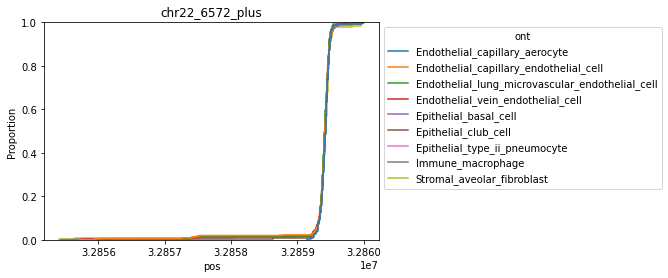

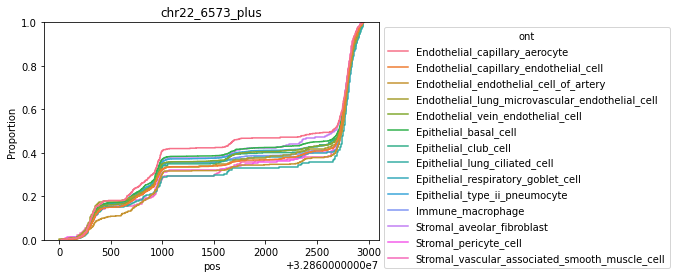

In [71]:
for window,plot_g in agg_counts.groupby('window'):
    
    #"explode" counts so I can use ecdfplot
    data = {
        'ont':[],
        'pos':[],
    }
    for i,r in plot_g.iterrows():
        data['ont'].extend([r['ont']]*r['count'])
        data['pos'].extend([r['pos']]*r['count'])

    long_agg_df = pd.DataFrame(data)
    
    ax = sns.ecdfplot(
        x = 'pos',
        hue = 'ont',
        data = long_agg_df,
    )
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.title(window)
    plt.show()
    plt.close()

In [112]:
# looks exciting, writing out a bedGraph for each window so I can see on the browser
bin_size = 10

#hardcoding Timp3 3' UTR
chrom = 'chr22'
min_val = 32859048
max_val = 32863111


bins = np.arange(min_val,max_val,bin_size)
bin_labels = pd.Categorical(bins[:-1])

agg_counts['bin'] = pd.cut(agg_counts['pos'], bins=bins)
agg_counts['chr'] = chrom

windows = agg_counts['window'].unique()
ont_z_proxies = {}
cumsums = {}
densities = {}

for window in windows:
    window_g = agg_counts[agg_counts['window'].eq(window)]
    
    ont_z_proxies[window] = []
    cumsums[window] = {}
    densities[window] = {}
    
    for ont,g in window_g.groupby('ont'):

        tot_counts = g['count'].sum()

        bin_counts = g.groupby(['chr','bin'])['count'].sum().fillna(0)
        norm_bin_counts = bin_counts/bin_counts.max()
        cs_counts = bin_counts.cumsum()/tot_counts

        #Calculate the cumsum table
        cs_df = cs_counts.reset_index()
        cs_df['left'] = cs_df['bin'].apply(lambda v: v.left)
        cs_df['right'] = cs_df['bin'].apply(lambda v: v.right)
        cumsums[window][ont] = cs_df
        
        #Calculate the density table
        density_df = norm_bin_counts.reset_index()
        density_df['left'] = density_df['bin'].apply(lambda v: v.left)
        density_df['right'] = density_df['bin'].apply(lambda v: v.right)
        densities[window][ont] = density_df

        z_proxy = cs_df['left'].astype(int).multiply(cs_df['count']).sum()
        ont_z_proxies[window].append((z_proxy,ont))

        
for window in windows:
    num_onts = len(ont_z_proxies[window])
    print(num_onts)
    colors = sns.color_palette('viridis',num_onts)
    
    for i,(z_prox,ont) in enumerate(sorted(ont_z_proxies[window])):
        i_str = str(i).zfill(2)
        
        print(window,z_prox,ont)
        
        red,green,blue = colors[i]
        red,green,blue = int(256*red),int(256*green),int(256*blue)
        
        #Write out the cumulative table
        cs_out_path = 'timp3_window_lung_bedGraphs/{}_{}_{}.bedGraph'.format(window,i_str,ont).replace(' ','_')
        
        with open(cs_out_path,'w') as f_out:
            f_out.write('browser position {}:{}-{}\n'.format(chrom,min_val,max_val))
            f_out.write('track type=bedGraph name="cs {}" visibility=hide maxHeightPixels=50 graphType=points color={},{},{} visibility=hide\n'.format(ont,red,green,blue))

        cs_df = cumsums[window][ont]
        cs_df[['chr','left','right','count']].to_csv(cs_out_path, mode='a', header=None, sep=' ', index=None)
            
        #Write out the density table
        density_out_path = 'timp3_window_lung_bedGraphs/density_{}_{}_{}.bedGraph'.format(window,i_str,ont).replace(' ','_')

        with open(density_out_path,'w') as f_out:
            f_out.write('browser position {}:{}-{}\n'.format(chrom,min_val,max_val))
            f_out.write('track type=bedGraph name="{}" visibility=full maxHeightPixels=50 graphType=points color={},{},{} visibility=hide\n'.format(ont,red,green,blue))

        density_df = densities[window][ont]
        density_df[['chr','left','right','count']].to_csv(density_out_path, mode='a', header=None, sep=' ', index=None)
        

9
chr22_6572_plus 11855172629.94529 Endothelial_capillary_endothelial_cell
chr22_6572_plus 11920494841.23409 Immune_macrophage
chr22_6572_plus 11921719227.804512 Stromal_aveolar_fibroblast
chr22_6572_plus 11952869481.132421 Epithelial_type_ii_pneumocyte
chr22_6572_plus 11958968184.097164 Endothelial_lung_microvascular_endothelial_cell
chr22_6572_plus 11961086351.869022 Endothelial_vein_endothelial_cell
chr22_6572_plus 11968702836.16949 Epithelial_basal_cell
chr22_6572_plus 12044478084.008404 Epithelial_club_cell
chr22_6572_plus 12132689869.926472 Endothelial_capillary_aerocyte
14
chr22_6573_plus 3337905046.3794465 Epithelial_lung_ciliated_cell
chr22_6573_plus 3416827489.7359853 Endothelial_endothelial_cell_of_artery
chr22_6573_plus 3504637798.706383 Stromal_vascular_associated_smooth_muscle_cell
chr22_6573_plus 3545082946.3641796 Stromal_pericyte_cell
chr22_6573_plus 3649407476.243871 Endothelial_capillary_endothelial_cell
chr22_6573_plus 3692199674.89697 Epithelial_respiratory_goblet_

'13'

In [106]:
'{:2}'.format(8)

'18'

In [98]:
len(ont_z_proxies[window])

9

In [82]:
cs_df['left'].astype(int)

0      32859048
1      32859058
2      32859068
3      32859078
4      32859088
         ...   
401    32863058
402    32863068
403    32863078
404    32863088
405    32863098
Name: left, Length: 406, dtype: int64

In [2]:
import glob


In [29]:
import pandas as pd
df = pd.read_csv('/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/outputs/gene_cell/filt_out_one_count_gene/sample_sheet.csv')
df

,study,metric,sample,path
0,BICCN,central,mouse1sample1,BICCN_mouse1sample1_central.csv
1,BICCN,peripheral,mouse1sample1,BICCN_mouse1sample1_peripheral.csv
2,BICCN,punctate,mouse1sample1,BICCN_mouse1sample1_punctate.csv
3,BICCN,radial,mouse1sample1,BICCN_mouse1sample1_radial.csv
4,BICCN,central,mouse1sample2,BICCN_mouse1sample2_central.csv
...,...,...,...,...
91,CZB_liver,radial,CZB_liver,CZB_liver_radial.csv
92,seqfish,central,seqfish,seqfish_plus_central.csv
93,seqfish,peripheral,seqfish,seqfish_plus_peripheral.csv
94,seqfish,punctate,seqfish,seqfish_plus_punctate.csv


In [30]:
df[df['path'].isnull()]

,study,metric,sample,path


In [31]:
df['study'].value_counts()

BICCN         48
Brainmap      36
CZB_kidney     4
CZB_liver      4
seqfish        4
Name: study, dtype: int64

In [32]:
df['metric'].value_counts()

central       24
peripheral    24
punctate      24
radial        24
Name: metric, dtype: int64

In [33]:
df['sample'].value_counts()

mouse1sample1        4
mouse1sample2        4
CZB_liver            4
CZB_kidney           4
Slice3_Replicate3    4
Slice3_Replicate2    4
Slice3_Replicate1    4
Slice2_Replicate3    4
Slice2_Replicate2    4
Slice2_Replicate1    4
Slice1_Replicate3    4
Slice1_Replicate2    4
Slice1_Replicate1    4
mouse2sample6        4
mouse2sample5        4
mouse2sample4        4
mouse2sample3        4
mouse2sample2        4
mouse2sample1        4
mouse1sample6        4
mouse1sample5        4
mouse1sample4        4
mouse1sample3        4
seqfish              4
Name: sample, dtype: int64

# Timp3 miR binding sites from Jui paper reference

In [5]:
import pandas as pd

In [12]:
#these positions are distance from the start of the 3' UTR which is at 32,859,378 in hg38
miR_bindings = [
    ('miR-17',1351,1357),
    ('miR-17',101,123),
    ('miR-17',524,545),
    ('miR-21',1032,1039),
    ('miR-21',2322,2329),
    ('miR-34b',1282,1288),
    ('miR-136',2582,2600),
    ('miR-142',55,61),
    ('miR-181b',797,811),
    ('miR-181b',3499,3505),
    ('miR-181b',3573,3580),
    ('miR-191',3553,3573),
    ('miR-205',3495,3500),
    ('miR-206',1135,1146),
    ('miR-206',1683,1689),
    ('miR-221',2429,2450),
    ('miR-222',2443,2449),
    ('miR-323a',3590,3596),
    ('miR-365',336,342),
    ('miR-373',112,118),
    ('miR-770',227,232),
]

miR_df = pd.DataFrame(miR_bindings,columns=['miR','start','end'])
miR_df['start'] += 32859378
miR_df['end'] += 32859378

miR_df['exon_number'] = miR_df.groupby('miR').cumcount()+1
miR_df

,miR,start,end,exon_number
0,miR-17,32860729,32860735,1
1,miR-17,32859479,32859501,2
2,miR-17,32859902,32859923,3
3,miR-21,32860410,32860417,1
4,miR-21,32861700,32861707,2
5,miR-34b,32860660,32860666,1
6,miR-136,32861960,32861978,1
7,miR-142,32859433,32859439,1
8,miR-181b,32860175,32860189,1
9,miR-181b,32862877,32862883,2


In [ ]:
#Example of BED I want to make
browser position chr22:32859048-32863111
track name="miRNA binding sites"
chr7	127471196	127472363	Pos1	0	+	127471196	127472363	255,0,0
chr7	127472363	127473530	Pos2	0	+	127472363	127473530	255,0,0
chr7	127473530	127474697	Pos3	0	+	127473530	127474697	255,0,0

In [19]:
with open('miR_timp3_hg38.gtf','w') as f_out:
    f_out.write('browser position chr22:32859048-32863111\n')
    f_out.write('track type=gtf name="miRNA binding sites"\n')
    
    for i,r in miR_df.iterrows():
        out_data = (
            'chr22',
            'test',
            'exon',
            str(r['start']),
            str(r['end']),
            '.',
            '+',
            '.',
            'gene_id "{}"; transcript_id "{}"; exon_number 1'.format(r['miR'],r['miR']),
        )
        
        f_out.write('\t'.join(out_data)+'\n')
        
        

# Timp2 Sierra plot from heart conditions

Myocardia vs control

In [44]:
import pandas as pd
import numpy as np

In [47]:
counts_df = pd.read_csv(
    'sierra_myocardia_readzs_output/Sierra_day3_GFP_min10cellsmin5cts_chr11.txt',
    sep = '\t',
    header = None,
    names = ['cell_id','chr','pos','strand','count','sample','window'],
)

#filter to just Timp2 3' UTR reads
chrom = 'chr11'
start = 118300841
end = 118304046
strand = '-'

counts_df = counts_df[
    counts_df['chr'].eq(chrom) &
    counts_df['strand'].eq(strand) &
    counts_df['pos'].between(start,end)
]

count_windows = counts_df['window'].unique()

counts_df

,cell_id,chr,pos,strand,count,sample,window
3360048,Sierra_mouse_heart_MI_day3_GFP_ACGCCAGCAGCTGTAT,chr11,118301069,-,1,Sierra_mouse_heart_MI_day3_GFP,chr11_23661_minus
3360049,Sierra_mouse_heart_MI_day3_GFP_TTGGCAACATTGAGCT,chr11,118301159,-,1,Sierra_mouse_heart_MI_day3_GFP,chr11_23661_minus
3360050,Sierra_mouse_heart_MI_day3_GFP_CTCTACGAGAGCTGGT,chr11,118301191,-,1,Sierra_mouse_heart_MI_day3_GFP,chr11_23661_minus
3360051,Sierra_mouse_heart_MI_day3_GFP_GTCCTCAAGAAACCAT,chr11,118301063,-,1,Sierra_mouse_heart_MI_day3_GFP,chr11_23661_minus
3360052,Sierra_mouse_heart_MI_day3_GFP_GGGATGAGTAGGCATG,chr11,118301183,-,1,Sierra_mouse_heart_MI_day3_GFP,chr11_23661_minus
...,...,...,...,...,...,...,...
4171968,Sierra_mouse_heart_Sham_day3_GFP_ATCTACTTCCGCAAGC,chr11,118303773,-,1,Sierra_mouse_heart_Sham_day3_GFP,chr11_23661_minus
4171969,Sierra_mouse_heart_Sham_day3_GFP_TTTGCGCGTTGACGTT,chr11,118303774,-,1,Sierra_mouse_heart_Sham_day3_GFP,chr11_23661_minus
4171970,Sierra_mouse_heart_Sham_day3_GFP_GGCGACTCACAGATTC,chr11,118303774,-,1,Sierra_mouse_heart_Sham_day3_GFP,chr11_23661_minus
4171971,Sierra_mouse_heart_Sham_day3_GFP_CTCGGGAAGTTCGCGC,chr11,118303774,-,1,Sierra_mouse_heart_Sham_day3_GFP,chr11_23661_minus


In [48]:
z_df = pd.read_csv(
    'sierra_myocardia_readzs_output/Sierra_day3_GFP_min10cellsmin5cts_chr11.zscore',
    sep = '\t',
)

#Filter to just the windows of interest
z_df = z_df.dropna()
z_df = z_df[
    z_df['window'].isin(count_windows)
][['cell_id','cluster','injury']]

z_df

,cell_id,cluster,injury
345,Sierra_mouse_heart_MI_day3_GFP_AAACCTGAGATGTTAG,F-Act,MI
788,Sierra_mouse_heart_MI_day3_GFP_AAACCTGAGGTGTTAA,F-Cyc,MI
1121,Sierra_mouse_heart_MI_day3_GFP_AAACCTGAGTAGCGGT,F-WntX,MI
1816,Sierra_mouse_heart_MI_day3_GFP_AAACCTGAGTTAGGTA,F-Cyc,MI
2105,Sierra_mouse_heart_MI_day3_GFP_AAACCTGCAAGTTCTG,F-SL,MI
...,...,...,...
2452781,Sierra_mouse_heart_Sham_day3_GFP_TTTGGTTAGCGATCCC,F-Act,Sham
2453236,Sierra_mouse_heart_Sham_day3_GFP_TTTGTCAAGATATACG,F-Act,Sham
2453532,Sierra_mouse_heart_Sham_day3_GFP_TTTGTCACAAAGTGCG,F-Trans,Sham
2453677,Sierra_mouse_heart_Sham_day3_GFP_TTTGTCACAAGCCATT,F-SH,Sham


In [49]:
#Merge to get the cluster and injury info
m = counts_df.merge(z_df)
m

,cell_id,chr,pos,strand,count,sample,window,cluster,injury
0,Sierra_mouse_heart_MI_day3_GFP_CTCTACGAGAGCTGGT,chr11,118301191,-,1,Sierra_mouse_heart_MI_day3_GFP,chr11_23661_minus,F-Cyc,MI
1,Sierra_mouse_heart_MI_day3_GFP_CTCTACGAGAGCTGGT,chr11,118301199,-,1,Sierra_mouse_heart_MI_day3_GFP,chr11_23661_minus,F-Cyc,MI
2,Sierra_mouse_heart_MI_day3_GFP_CTCTACGAGAGCTGGT,chr11,118301218,-,1,Sierra_mouse_heart_MI_day3_GFP,chr11_23661_minus,F-Cyc,MI
3,Sierra_mouse_heart_MI_day3_GFP_CTCTACGAGAGCTGGT,chr11,118301991,-,1,Sierra_mouse_heart_MI_day3_GFP,chr11_23661_minus,F-Cyc,MI
4,Sierra_mouse_heart_MI_day3_GFP_CTCTACGAGAGCTGGT,chr11,118302041,-,1,Sierra_mouse_heart_MI_day3_GFP,chr11_23661_minus,F-Cyc,MI
...,...,...,...,...,...,...,...,...,...
32806,Sierra_mouse_heart_Sham_day3_GFP_CAACCTCAGACGACGT,chr11,118303735,-,1,Sierra_mouse_heart_Sham_day3_GFP,chr11_23661_minus,F-SL,Sham
32807,Sierra_mouse_heart_Sham_day3_GFP_CGCCAAGCAAACTGTC,chr11,118303748,-,1,Sierra_mouse_heart_Sham_day3_GFP,chr11_23661_minus,F-SL,Sham
32808,Sierra_mouse_heart_Sham_day3_GFP_GCGCGATCACGAAAGC,chr11,118303713,-,1,Sierra_mouse_heart_Sham_day3_GFP,chr11_23661_minus,F-SL,Sham
32809,Sierra_mouse_heart_Sham_day3_GFP_CTCTACGCAATCTGCA,chr11,118303717,-,1,Sierra_mouse_heart_Sham_day3_GFP,chr11_23661_minus,F-SL,Sham


In [50]:
m['cluster'].unique()

array(['F-Cyc', 'F-Act', 'F-SH', 'F-Trans', 'F-WntX', 'F-SL', 'MAC',
       'F-IFNS', 'MYO', 'EPI', 'EC'], dtype=object)

In [51]:
m['injury'].unique()

array(['MI', 'Sham'], dtype=object)

In [54]:
import seaborn as sns

bin_size = 10
df = m.copy()

genes = ['Timp2','Timp3']

for gene in genes:

    if gene == 'Timp2':
        #hardcoding mouse Timp2 3' UTR
        chrom = 'chr11'
        min_val = 118300841
        max_val = 118304046

    elif gene == 'Timp3':
        chrom = 'chr10'
        min_val = 86345388
        max_val = 86350338

    else:
        print('oh no! gene not found')



    df = df[df['pos'].between(min_val,max_val)]
    df = df.groupby(['injury','cluster']).filter(lambda g: g['count'].sum() >= 100)

    bins = np.arange(min_val,max_val,bin_size)
    bin_labels = pd.Categorical(bins[:-1])

    df['bin'] = pd.cut(df['pos'], bins=bins)
    
    print(gene,df.shape)

    for injury,injury_g in df.groupby('injury'):
        num_onts = injury_g['cluster'].nunique()
        colors = sns.color_palette('viridis',num_onts)

        for i,(ont,g) in enumerate(injury_g.groupby('cluster')):
            injury = injury.replace(' ','_')
            ont = ont.replace(' ','_')

            red,green,blue = colors[i]
            red,green,blue = int(256*red),int(256*green),int(256*blue)

            tot_counts = g['count'].sum()

            bin_counts = g.groupby(['chr','bin'])['count'].sum().fillna(0)
            norm_bin_counts = bin_counts#/bin_counts.max()
            cs_counts = bin_counts.cumsum()/tot_counts

            #Write out the cumulative table
            cs_out_path = f'heart_bedGraphs/sierra_{gene}_{injury}_{ont}.bedGraph'

            with open(cs_out_path,'w') as f_out:
                f_out.write(f'browser position {chrom}:{min_val}-{max_val}\n')
                f_out.write(f'track type=bedGraph name="cs {injury} {ont}" visibility=hide maxHeightPixels=50 graphType=points\n')

            cs_df = cs_counts.reset_index()
            cs_df['left'] = cs_df['bin'].apply(lambda v: v.left)
            cs_df['right'] = cs_df['bin'].apply(lambda v: v.right)
            cs_df[['chr','left','right','count']].to_csv(cs_out_path, mode='a', header=None, sep=' ', index=None)

            #Write out the density table
            density_out_path = f'heart_bedGraphs/sierra_density_{gene}_{injury}_{ont}.bedGraph'

            with open(density_out_path,'w') as f_out:
                f_out.write(f'browser position {chrom}:{min_val}-{max_val}\n')
                f_out.write(f'track type=bedGraph name="{injury} {ont}" visibility=full maxHeightPixels=50 graphType=bar\n')

            density_df = norm_bin_counts.reset_index()
            density_df['left'] = density_df['bin'].apply(lambda v: v.left)
            density_df['right'] = density_df['bin'].apply(lambda v: v.right)
            density_df[['chr','left','right','count']].to_csv(density_out_path, mode='a', header=None, sep=' ', index=None)


Timp2 (32660, 10)
Timp3 (0, 10)


# Timp2 miR predicted binding sites from miRBase

In [16]:
mouse_timp2_miRs = [
    ('mmu-miR-544-3p',378),
    ('mmu-miR-434-3p',2024),
    ('mmu-miR-6384',2041),
    ('mmu-miR-1905',50),
    ('mmu-miR-1905',1225),
    ('mmu-miR-106a-5p',1857),
    ('mmu-miR-6383',1857),
    ('mmu-miR-93-5p',1857),
    ('mmu-miR-17-5p',1857),
]

miR_df = pd.DataFrame(mouse_timp2_miRs, columns=['miR','pos'])
miR_df['pos'] = 118303702-miR_df['pos']

with open('miR_timp2_mm.bed','w') as f_out:
    f_out.write('browser position chr11:118300841-118304046\n')
    f_out.write('track type=bed name="miRNA binding sites"\n')
    
    for i,r in miR_df.iterrows():
        out_data = (
            'chr11',
            str(r['pos']),
            str(r['pos']+50),
            r['miR'],
        )
        
        f_out.write('\t'.join(out_data)+'\n')
        
        

In [13]:
print('hello')

hello


# Timp3 Sierra plot from heart conditions

In [18]:
import pandas as pd
import numpy as np

In [17]:
counts_df = pd.read_csv(
    '/scratch/groups/horence/Elisabeth/intron_zscore/nextflow_dedup_options/Sierra/Sierra_day3_GFP_fixedBH_min10cellsmin5cts/counts/Sierra_day3_GFP_min10cellsmin5cts_chr10.txt',
    sep = '\t',
    header = None,
    names = ['cell_id','chr','pos','strand','count','sample','window'],
)

#filter to just Timp3 3' UTR reads
chrom = 'chr10'
start = 86345548
end = 86349641
strand = '+'

counts_df = counts_df[
    counts_df['chr'].eq(chrom) &
    counts_df['strand'].eq(strand) &
    counts_df['pos'].between(start,end)
]

count_windows = counts_df['window'].unique()

counts_df

,cell_id,chr,pos,strand,count,sample,window
1573028,Sierra_mouse_heart_MI_day3_GFP_CCTACACTCAGTGCAT,chr10,86345901,+,1,Sierra_mouse_heart_MI_day3_GFP,chr10_17270_plus
1573029,Sierra_mouse_heart_MI_day3_GFP_GAAATGAGTTTGTGTG,chr10,86345753,+,1,Sierra_mouse_heart_MI_day3_GFP,chr10_17270_plus
1573030,Sierra_mouse_heart_MI_day3_GFP_CTTCTCTCAAACTGTC,chr10,86345768,+,1,Sierra_mouse_heart_MI_day3_GFP,chr10_17270_plus
1573031,Sierra_mouse_heart_MI_day3_GFP_GGACAAGAGCCACCTG,chr10,86345930,+,1,Sierra_mouse_heart_MI_day3_GFP,chr10_17270_plus
1573032,Sierra_mouse_heart_MI_day3_GFP_CCGTTCACAGGATCGA,chr10,86345798,+,1,Sierra_mouse_heart_MI_day3_GFP,chr10_17270_plus
...,...,...,...,...,...,...,...
2896924,Sierra_mouse_heart_Sham_day3_GFP_CACTCCAAGGACCACA,chr10,86349379,+,1,Sierra_mouse_heart_Sham_day3_GFP,chr10_17270_plus
2896925,Sierra_mouse_heart_Sham_day3_GFP_AGACGTTAGGCATTGG,chr10,86349380,+,1,Sierra_mouse_heart_Sham_day3_GFP,chr10_17270_plus
2896926,Sierra_mouse_heart_Sham_day3_GFP_AGGCCACAGCTCCTCT,chr10,86349380,+,1,Sierra_mouse_heart_Sham_day3_GFP,chr10_17270_plus
2896927,Sierra_mouse_heart_Sham_day3_GFP_CGGCTAGCAGGGTATG,chr10,86349380,+,1,Sierra_mouse_heart_Sham_day3_GFP,chr10_17270_plus


In [19]:
count_windows

array(['chr10_17270_plus'], dtype=object)

In [20]:
z_df = pd.read_csv(
    '/scratch/groups/horence/Elisabeth/intron_zscore/nextflow_dedup_options/Sierra/Sierra_day3_GFP_fixedBH_min10cellsmin5cts/zscore/Sierra_day3_GFP_min10cellsmin5cts_chr10.zscore',
    sep = '\t',
)

#Filter to just the windows of interest
z_df = z_df.dropna()
z_df = z_df[
    z_df['window'].isin(count_windows)
][['cell_id','cluster','injury']]

z_df

,cell_id,cluster,injury
185,Sierra_mouse_heart_MI_day3_GFP_AAACCTGAGATGTTAG,F-Act,MI
486,Sierra_mouse_heart_MI_day3_GFP_AAACCTGAGTAGCGGT,F-WntX,MI
841,Sierra_mouse_heart_MI_day3_GFP_AAACCTGAGTTAGGTA,F-Cyc,MI
1309,Sierra_mouse_heart_MI_day3_GFP_AAACCTGCAATCTACG,F-WntX,MI
2742,Sierra_mouse_heart_MI_day3_GFP_AAACGGGAGTGTACCT,F-Act,MI
...,...,...,...
1540799,Sierra_mouse_heart_Sham_day3_GFP_TTTGCGCGTTACGACT,F-SH,Sham
1540930,Sierra_mouse_heart_Sham_day3_GFP_TTTGCGCGTTGACGTT,F-Trans,Sham
1541785,Sierra_mouse_heart_Sham_day3_GFP_TTTGTCAAGATATACG,F-Act,Sham
1541944,Sierra_mouse_heart_Sham_day3_GFP_TTTGTCACAAAGTGCG,F-Trans,Sham


In [21]:
#Merge to get the cluster and injury info
m = counts_df.merge(z_df)
m

,cell_id,chr,pos,strand,count,sample,window,cluster,injury
0,Sierra_mouse_heart_MI_day3_GFP_CCTACACTCAGTGCAT,chr10,86345901,+,1,Sierra_mouse_heart_MI_day3_GFP,chr10_17270_plus,F-Act,MI
1,Sierra_mouse_heart_MI_day3_GFP_CCTACACTCAGTGCAT,chr10,86345928,+,1,Sierra_mouse_heart_MI_day3_GFP,chr10_17270_plus,F-Act,MI
2,Sierra_mouse_heart_MI_day3_GFP_CCTACACTCAGTGCAT,chr10,86347112,+,1,Sierra_mouse_heart_MI_day3_GFP,chr10_17270_plus,F-Act,MI
3,Sierra_mouse_heart_MI_day3_GFP_CCTACACTCAGTGCAT,chr10,86348129,+,1,Sierra_mouse_heart_MI_day3_GFP,chr10_17270_plus,F-Act,MI
4,Sierra_mouse_heart_MI_day3_GFP_CCTACACTCAGTGCAT,chr10,86348246,+,1,Sierra_mouse_heart_MI_day3_GFP,chr10_17270_plus,F-Act,MI
...,...,...,...,...,...,...,...,...,...
18442,Sierra_mouse_heart_Sham_day3_GFP_TCACAAGTCACAAACC,chr10,86349356,+,1,Sierra_mouse_heart_Sham_day3_GFP,chr10_17270_plus,F-SL,Sham
18443,Sierra_mouse_heart_Sham_day3_GFP_CCGTTCATCATATCGG,chr10,86349368,+,1,Sierra_mouse_heart_Sham_day3_GFP,chr10_17270_plus,F-Cyc,Sham
18444,Sierra_mouse_heart_Sham_day3_GFP_GGACATTTCCACGTTC,chr10,86349369,+,1,Sierra_mouse_heart_Sham_day3_GFP,chr10_17270_plus,F-WntX,Sham
18445,Sierra_mouse_heart_Sham_day3_GFP_CACCTTGGTCGCGGTT,chr10,86349377,+,1,Sierra_mouse_heart_Sham_day3_GFP,chr10_17270_plus,F-SH,Sham


In [23]:
import seaborn as sns

bin_size = 10
df = m.copy()

#hardcoding mouse Timp3 3' UTR
chrom = 'chr10'
min_val = 86345548
max_val = 86349641

df = df[df['pos'].between(min_val,max_val)]
df = df.groupby(['injury','cluster']).filter(lambda g: g['count'].sum() >= 100)

bins = np.arange(min_val,max_val,bin_size)
bin_labels = pd.Categorical(bins[:-1])

df['bin'] = pd.cut(df['pos'], bins=bins)

for injury,injury_g in df.groupby('injury'):
    num_onts = injury_g['cluster'].nunique()
    colors = sns.color_palette('viridis',num_onts)
    
    for i,(ont,g) in enumerate(injury_g.groupby('cluster')):
        
        red,green,blue = colors[i]
        red,green,blue = int(256*red),int(256*green),int(256*blue)

        tot_counts = g['count'].sum()

        bin_counts = g.groupby(['chr','bin'])['count'].sum().fillna(0)
        norm_bin_counts = bin_counts/bin_counts.max()
        cs_counts = bin_counts.cumsum()/tot_counts

        #Write out the cumulative table
        cs_out_path = 'bedGraphs/sierra_Timp3_{}_{}.bedGraph'.format(injury,ont).replace(' ','_')
        
        with open(cs_out_path,'w') as f_out:
            f_out.write('browser position {}:{}-{}\n'.format(chrom,min_val,max_val))
            f_out.write('track type=bedGraph name="cs {} {}" visibility=hide maxHeightPixels=50 graphType=points color={},{},{} visibility=hide\n'.format(injury,ont,red,green,blue))

        cs_df = cs_counts.reset_index()
        cs_df['left'] = cs_df['bin'].apply(lambda v: v.left)
        cs_df['right'] = cs_df['bin'].apply(lambda v: v.right)
        cs_df[['chr','left','right','count']].to_csv(cs_out_path, mode='a', header=None, sep=' ', index=None)

        #Write out the density table
        density_out_path = 'bedGraphs/sierra_Timp3_density_{}_{}.bedGraph'.format(injury,ont).replace(' ','_')

        with open(density_out_path,'w') as f_out:
            f_out.write('browser position {}:{}-{}\n'.format(chrom,min_val,max_val))
            f_out.write('track type=bedGraph name="{} {}" visibility=full maxHeightPixels=50 graphType=points color={},{},{} visibility=hide\n'.format(injury,ont,red,green,blue))

        density_df = norm_bin_counts.reset_index()
        density_df['left'] = density_df['bin'].apply(lambda v: v.left)
        density_df['right'] = density_df['bin'].apply(lambda v: v.right)
        density_df[['chr','left','right','count']].to_csv(density_out_path, mode='a', header=None, sep=' ', index=None)
        

# Writing Timp3 bed file for miRs

In [26]:
mouse_timp2_miRs = [
    #('mmu-miR-221-3p',2383),
    ('mmu-miR-221-3p',3462),
    ('mmu-miR-181c-5p',1419), #Note, matching position from prior, miRDB position is the line below
    #('mmu-miR-181c-5p',2419),
    #('mmu-miR-181c-5p',3440),
    #("mmu-miR-181c-5p",3514),
]

miR_df = pd.DataFrame(mouse_timp2_miRs, columns=['miR','pos'])
miR_df['pos'] += 86345912

with open('miR_timp3_mm.bed','w') as f_out:
    f_out.write('browser position chr10:86345548-86349641\n')
    f_out.write('track type=bed name="miRNA binding sites"\n')
    
    for i,r in miR_df.iterrows():
        out_data = (
            'chr10',
            str(r['pos']),
            str(r['pos']+50),
            r['miR'],
        )
        
        f_out.write('\t'.join(out_data)+'\n')
        
        

# Krasnow COVID 19 3' 10X human cell line Timp2/Timp3

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pysam
import glob
import os

meta_df = pd.read_csv(
    '/oak/stanford/groups/horence/Roozbeh/single_cell_project/utility_files/meta_data/COVID_10x/Infection_3/droplet-infection_3_3prime-adata-metadata.2021-02-03_modified.csv',
)

#renaming to match the renaming I did earlyier
meta_df['channel'] = meta_df['channel'].str.replace('Covid19_Pilot2_','').str.replace('_3prime','')
meta_df.head()

,channel,cultured,infected,culture_time,chemistry,n_counts,n_genes,predicted_doublets,viral_sense_umis,viral_antisense_umis,viral_total_umis,free_annotation,compartment,barcode,cell
0,0h_noncultured_Sample_1_S1,False,False,0,3prime,1158,658,False,NaN,NaN,NaN,CD4+ Effector/Memory T,Immune,AAACCCACAATCGAAA,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_...
1,0h_noncultured_Sample_1_S1,False,False,0,3prime,811,537,False,NaN,NaN,NaN,Capillary Aerocyte,Endothelial,AAACCCACACCCAACG,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_...
2,0h_noncultured_Sample_1_S1,False,False,0,3prime,900,550,False,NaN,NaN,NaN,General Capillary,Endothelial,AAACCCAGTGTACATC,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_...
3,0h_noncultured_Sample_1_S1,False,False,0,3prime,26740,4976,False,NaN,NaN,NaN,Macrophage,Immune,AAACCCAGTTCGATTG,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_...
4,0h_noncultured_Sample_1_S1,False,False,0,3prime,27266,5516,False,NaN,NaN,NaN,Macrophage,Immune,AAACCCATCATCGCTC,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_...


In [12]:
meta_df['channel'].unique()

array(['0h_noncultured_Sample_1_S1', '24h_infected_Sample_1_S3',
       '24h_infected_Sample_2_S4', '24h_cultured_Sample_1_S2',
       '72h_infected_Sample_1_S6', '72h_infected_Sample_2_S7',
       '72h_cultured_Sample_1_S5', '96h_infected_Sample_1_S9',
       '96h_infected_Sample_2_S10', '96h_cultured_Sample_1_S8'],
      dtype=object)

In [13]:
stem = '/scratch/groups/horence/rob/data/krasnow_covid_10X_pilot4_201216'

samples = [ 
    (0,'noncultured','sample1','0h_noncultured_Sample_1_S1'), 
    (24,'cultured','sample1','24h_cultured_Sample_1_S2'), 
    (24,'infected','sample1','24h_infected_Sample_1_S3'), 
    (24,'infected','sample2','24h_infected_Sample_2_S4'), 
    (72,'cultured','sample1','72h_cultured_Sample_1_S5'), 
    (72,'infected','sample1','72h_infected_Sample_1_S6'), 
    (72,'infected','sample2','72h_infected_Sample_2_S7'), 
    (96,'cultured','sample1','96h_cultured_Sample_1_S8'), 
    (96,'infected','sample1','96h_infected_Sample_1_S9'), 
    (96,'infected','sample2','96h_infected_Sample_2_S10'), 
]

sample_df = pd.DataFrame(samples, columns=['hours','infection','sample_num','f_name'])
sample_df

,hours,infection,sample_num,f_name
0,0,noncultured,sample1,0h_noncultured_Sample_1_S1
1,24,cultured,sample1,24h_cultured_Sample_1_S2
2,24,infected,sample1,24h_infected_Sample_1_S3
3,24,infected,sample2,24h_infected_Sample_2_S4
4,72,cultured,sample1,72h_cultured_Sample_1_S5
5,72,infected,sample1,72h_infected_Sample_1_S6
6,72,infected,sample2,72h_infected_Sample_2_S7
7,96,cultured,sample1,96h_cultured_Sample_1_S8
8,96,infected,sample1,96h_infected_Sample_1_S9
9,96,infected,sample2,96h_infected_Sample_2_S10


In [14]:
meta_df.columns

Index(['channel', 'cultured', 'infected', 'culture_time', 'chemistry',
       'n_counts', 'n_genes', 'predicted_doublets', 'viral_sense_umis',
       'viral_antisense_umis', 'viral_total_umis', 'free_annotation',
       'compartment', 'barcode', 'cell'],
      dtype='object')

In [15]:
%%time
regions = {
    'Timp2_3UTR_hg38':('chr17',78852555,78856177),
    'Timp3_3UTR_hg38':('chr22',32859082, 32863098),
}

data = {
    'gene':[],
    'f_name':[],
    'infection':[],
    'culture_time':[],
    'compartment':[],
    'free_annotation':[],
    'pos':[],
}

for i,r in sample_df.iterrows():
    print(r['f_name'])
    sub_meta_df = meta_df[meta_df['channel'].eq(r['f_name'])]
    
    bam_path = os.path.join(stem,r['f_name']+'.bam')
    bam = pysam.AlignmentFile(bam_path)
    
    for gene,region in regions.items():
        for read in bam.fetch(*region):
            #low quality read filtered out
            if read.mapq < 255 or len(read.cigar) > 1:
                continue
            
            _,bc,umi = read.query_name.split('_')
            
            cell_meta_df = sub_meta_df[sub_meta_df['barcode'].eq(bc)]
            
            if cell_meta_df.shape[0] == 0:
                compartment, free_annotation = None, None
            else:
                cell_meta_info = cell_meta_df.iloc[0]
                compartment = cell_meta_info['compartment']
                free_annotation = cell_meta_info['free_annotation']
            
            data['gene'].append(gene)
            data['f_name'].append(r['f_name'])
            data['infection'].append(r['infection'])
            data['culture_time'].append(r['hours'])
            data['compartment'].append(compartment)
            data['free_annotation'].append(free_annotation)
            data['pos'].append(read.pos)
            
    print(len(data))
            
pos_df = pd.DataFrame(data)
pos_df

0h_noncultured_Sample_1_S1
7
24h_cultured_Sample_1_S2
7
24h_infected_Sample_1_S3
7
24h_infected_Sample_2_S4
7
72h_cultured_Sample_1_S5
7
72h_infected_Sample_1_S6
7
72h_infected_Sample_2_S7
7
96h_cultured_Sample_1_S8
7
96h_infected_Sample_1_S9
7
96h_infected_Sample_2_S10
7


,gene,f_name,infection,culture_time,compartment,free_annotation,pos
0,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852516
1,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852526
2,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852526
3,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852530
4,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852568
...,...,...,...,...,...,...,...
401715,Timp3_3UTR_hg38,96h_infected_Sample_2_S10,infected,96,Immune,Macrophage,32862963
401716,Timp3_3UTR_hg38,96h_infected_Sample_2_S10,infected,96,None,None,32862963
401717,Timp3_3UTR_hg38,96h_infected_Sample_2_S10,infected,96,Epithelial,Alveolar Epithelial Type 1,32862964
401718,Timp3_3UTR_hg38,96h_infected_Sample_2_S10,infected,96,None,None,32862966


In [16]:
pos_df.to_csv('krasnow_covid_10X_3prime_timp2_timp3_read_positions.csv',index=False)

In [17]:
pos_df.shape

(401720, 7)

In [18]:
pos_df = pos_df.dropna()
pos_df

,gene,f_name,infection,culture_time,compartment,free_annotation,pos
0,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852516
1,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852526
2,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852526
3,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852530
4,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852568
...,...,...,...,...,...,...,...
401710,Timp3_3UTR_hg38,96h_infected_Sample_2_S10,infected,96,Endothelial,Lymphatic,32862961
401711,Timp3_3UTR_hg38,96h_infected_Sample_2_S10,infected,96,Endothelial,Lymphatic,32862961
401714,Timp3_3UTR_hg38,96h_infected_Sample_2_S10,infected,96,Epithelial,Alveolar Epithelial Type 2,32862963
401715,Timp3_3UTR_hg38,96h_infected_Sample_2_S10,infected,96,Immune,Macrophage,32862963


In [19]:
pos_df['free_annotation'].nunique()

61

In [20]:
pos_df['tissue_info'] = pos_df['infection']+'_'+pos_df['culture_time'].astype(str)+'_hours'
pos_df.head()

/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/dev_env/lib64/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,gene,f_name,infection,culture_time,compartment,free_annotation,pos,tissue_info
0,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852516,noncultured_0_hours
1,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852526,noncultured_0_hours
2,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852526,noncultured_0_hours
3,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852530,noncultured_0_hours
4,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852568,noncultured_0_hours


In [21]:
pos_df = pos_df.groupby(['gene','tissue_info','compartment','free_annotation','pos'])['pos'].count().reset_index(name='count')
pos_df

,gene,tissue_info,compartment,free_annotation,pos,count
0,Timp2_3UTR_hg38,cultured_24_hours,Endothelial,Artery,78852981,1
1,Timp2_3UTR_hg38,cultured_24_hours,Endothelial,Artery,78853000,3
2,Timp2_3UTR_hg38,cultured_24_hours,Endothelial,Artery,78853004,1
3,Timp2_3UTR_hg38,cultured_24_hours,Endothelial,Artery,78853009,2
4,Timp2_3UTR_hg38,cultured_24_hours,Endothelial,Artery,78853017,1
...,...,...,...,...,...,...
84578,Timp3_3UTR_hg38,noncultured_0_hours,Stromal,Vascular Smooth Muscle,32862917,1
84579,Timp3_3UTR_hg38,noncultured_0_hours,Stromal,Vascular Smooth Muscle,32862923,2
84580,Timp3_3UTR_hg38,noncultured_0_hours,Stromal,Vascular Smooth Muscle,32862924,1
84581,Timp3_3UTR_hg38,noncultured_0_hours,Stromal,Vascular Smooth Muscle,32862926,1


In [22]:
pos_df.to_csv('agg_krasnow_covid_10X_3prime_timp2_timp3_read_positions.csv',index=False)

In [23]:
pos_df['consensus_prediction'] = pos_df['compartment']+'_'+pos_df['free_annotation']
pos_df

,gene,tissue_info,compartment,free_annotation,pos,count,consensus_prediction
0,Timp2_3UTR_hg38,cultured_24_hours,Endothelial,Artery,78852981,1,Endothelial_Artery
1,Timp2_3UTR_hg38,cultured_24_hours,Endothelial,Artery,78853000,3,Endothelial_Artery
2,Timp2_3UTR_hg38,cultured_24_hours,Endothelial,Artery,78853004,1,Endothelial_Artery
3,Timp2_3UTR_hg38,cultured_24_hours,Endothelial,Artery,78853009,2,Endothelial_Artery
4,Timp2_3UTR_hg38,cultured_24_hours,Endothelial,Artery,78853017,1,Endothelial_Artery
...,...,...,...,...,...,...,...
84578,Timp3_3UTR_hg38,noncultured_0_hours,Stromal,Vascular Smooth Muscle,32862917,1,Stromal_Vascular Smooth Muscle
84579,Timp3_3UTR_hg38,noncultured_0_hours,Stromal,Vascular Smooth Muscle,32862923,2,Stromal_Vascular Smooth Muscle
84580,Timp3_3UTR_hg38,noncultured_0_hours,Stromal,Vascular Smooth Muscle,32862924,1,Stromal_Vascular Smooth Muscle
84581,Timp3_3UTR_hg38,noncultured_0_hours,Stromal,Vascular Smooth Muscle,32862926,1,Stromal_Vascular Smooth Muscle


In [24]:
regions

{'Timp2_3UTR_hg38': ('chr17', 78852555, 78856177),
 'Timp3_3UTR_hg38': ('chr22', 32859082, 32863098)}

In [25]:
density_out_path

'bedGraphs/density_vasculature_smooth_muscle_cell.bedGraph'

In [26]:
pos_df = pd.read_csv('agg_krasnow_covid_10X_3prime_timp2_timp3_read_positions.csv')

In [27]:
pos_df['free_annotation'].eq('Lymphatic').any()

True

In [33]:
pos_df['gene'].value_counts()

Timp3_3UTR_hg38    53687
Timp2_3UTR_hg38    30896
Name: gene, dtype: int64

In [36]:
pos_df.head()

,gene,tissue_info,compartment,free_annotation,pos,count
0,Timp2_3UTR_hg38,cultured_24_hours,Endothelial,Artery,78852981,1
1,Timp2_3UTR_hg38,cultured_24_hours,Endothelial,Artery,78853000,3
2,Timp2_3UTR_hg38,cultured_24_hours,Endothelial,Artery,78853004,1
3,Timp2_3UTR_hg38,cultured_24_hours,Endothelial,Artery,78853009,2
4,Timp2_3UTR_hg38,cultured_24_hours,Endothelial,Artery,78853017,1


In [38]:
pos_df[pos_df['gene'].eq('Timp3_3UTR_hg38')]['compartment'].value_counts()

Endothelial    24440
Stromal        14587
Epithelial     11135
Immune          3525
Name: compartment, dtype: int64

In [43]:
bin_size = 10

genes = ['Timp2','Timp3']

for gene in genes:

    if gene == 'Timp3':
        #hardcoding Timp3 3' UTR hg38
        chrom = 'chr22'
        min_val = 32859082
        max_val = 32863098
        df = pos_df[pos_df['gene'].eq('Timp3_3UTR_hg38')].copy()

    elif gene == 'Timp2':
        #harcoding Timp2 3' UTR hg38
        chrom = 'chr17'
        min_val = 78852555
        max_val = 78856177
        df = pos_df[pos_df['gene'].eq('Timp2_3UTR_hg38')].copy()

    else:
        print('Error, gene not recognized')

    df['chr'] = chrom

    df = df[df['pos'].between(min_val,max_val)]
    df = df.groupby(['tissue_info','compartment']).filter(lambda g: g['count'].sum() >= 100)

    bins = np.arange(min_val,max_val,bin_size)
    bin_labels = pd.Categorical(bins[:-1])

    df['bin'] = pd.cut(df['pos'], bins=bins)

    for tissue,tissue_g in df.groupby('tissue_info'):
        num_onts = tissue_g['compartment'].nunique()
        colors = sns.color_palette('viridis',num_onts)

        for i,(ont,g) in enumerate(tissue_g.groupby('compartment')):

            red,green,blue = colors[i]
            red,green,blue = int(256*red),int(256*green),int(256*blue)

            tot_counts = g['count'].sum()

            bin_counts = g.groupby(['chr','bin'])['count'].sum().fillna(0)
            norm_bin_counts = bin_counts#/bin_counts.max()
            cs_counts = bin_counts.cumsum()/tot_counts

            #Write out the cumulative table
            cs_out_path = f'covid_bedGraphs/{ont}_COVID_{gene}_{tissue}.bedGraph'

            with open(cs_out_path,'w') as f_out:
                f_out.write('browser position {}:{}-{}\n'.format(chrom,min_val,max_val))
                f_out.write(f'track type=bedGraph name="cs {tissue}" visibility=hide maxHeightPixels=50 graphType=points\n')

            cs_df = cs_counts.reset_index()
            cs_df['left'] = cs_df['bin'].apply(lambda v: v.left)
            cs_df['right'] = cs_df['bin'].apply(lambda v: v.right)
            cs_df[['chr','left','right','count']].to_csv(cs_out_path, mode='a', header=None, sep=' ', index=None)

            #Write out the density table
            density_out_path = f'covid_bedGraphs/density_{ont}_COVID_{gene}_{tissue}.bedGraph'

            with open(density_out_path,'w') as f_out:
                f_out.write('browser position {}:{}-{}\n'.format(chrom,min_val,max_val))
                f_out.write(f'track type=bedGraph name="{tissue}" visibility=full maxHeightPixels=50 graphType=bar\n')

            density_df = norm_bin_counts.reset_index()
            density_df['left'] = density_df['bin'].apply(lambda v: v.left)
            density_df['right'] = density_df['bin'].apply(lambda v: v.right)
            density_df[['chr','left','right','count']].to_csv(density_out_path, mode='a', header=None, sep=' ', index=None)
        

In [127]:
pos_df['gene'].value_counts()

Timp3_3UTR_hg38    53687
Timp2_3UTR_hg38    30896
Name: gene, dtype: int64

In [130]:
pos_df[pos_df['gene'].eq('Timp3_3UTR_hg38')]['tissue_info'].unique()

array(['cultured_24_hours', 'cultured_72_hours', 'cultured_96_hours',
       'infected_24_hours', 'infected_72_hours', 'infected_96_hours',
       'noncultured_0_hours'], dtype=object)

# Checking if Timp2 endothelial cell population percentages change with time

In [7]:
df = pd.read_csv('agg_krasnow_covid_10X_3prime_timp2_timp3_read_positions.csv')
df['hours'] = df['tissue_info'].str.split('_').str[1].astype(int)
df

,gene,tissue_info,compartment,free_annotation,pos,count,hours
0,Timp2_3UTR_hg38,cultured_24_hours,Endothelial,Artery,78852981,1,24
1,Timp2_3UTR_hg38,cultured_24_hours,Endothelial,Artery,78853000,3,24
2,Timp2_3UTR_hg38,cultured_24_hours,Endothelial,Artery,78853004,1,24
3,Timp2_3UTR_hg38,cultured_24_hours,Endothelial,Artery,78853009,2,24
4,Timp2_3UTR_hg38,cultured_24_hours,Endothelial,Artery,78853017,1,24
...,...,...,...,...,...,...,...
84578,Timp3_3UTR_hg38,noncultured_0_hours,Stromal,Vascular Smooth Muscle,32862917,1,0
84579,Timp3_3UTR_hg38,noncultured_0_hours,Stromal,Vascular Smooth Muscle,32862923,2,0
84580,Timp3_3UTR_hg38,noncultured_0_hours,Stromal,Vascular Smooth Muscle,32862924,1,0
84581,Timp3_3UTR_hg38,noncultured_0_hours,Stromal,Vascular Smooth Muscle,32862926,1,0


In [13]:
counts_per_ann_time = df[
    df['gene'].eq('Timp2_3UTR_hg38') &
    df['compartment'].eq('Endothelial')
].groupby(
    ['hours','tissue_info','free_annotation']
)['count'].sum().reset_index()

counts_per_ann_time['tot_reads'] = (
    counts_per_ann_time.groupby('tissue_info')['count'].transform('sum')
)

counts_per_ann_time['ann_frac'] = counts_per_ann_time['count'].div(counts_per_ann_time['tot_reads'])

counts_per_ann_time

,hours,tissue_info,free_annotation,count,tot_reads,ann_frac
0,0,noncultured_0_hours,Artery,18,303,0.059406
1,0,noncultured_0_hours,Capillary Aerocyte,68,303,0.224422
2,0,noncultured_0_hours,General Capillary,50,303,0.165017
3,0,noncultured_0_hours,Lymphatic,141,303,0.465347
4,0,noncultured_0_hours,Vein,26,303,0.085809
5,24,cultured_24_hours,Artery,218,1429,0.152554
6,24,cultured_24_hours,Capillary Aerocyte,20,1429,0.013996
7,24,cultured_24_hours,General Capillary,15,1429,0.010497
8,24,cultured_24_hours,Lymphatic,885,1429,0.619314
9,24,cultured_24_hours,Vein,291,1429,0.203639


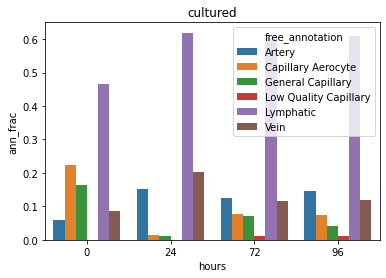

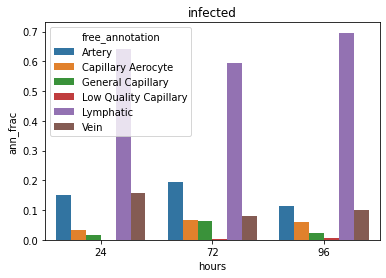

In [19]:
counts_per_ann_time['condition'] = np.where(
    counts_per_ann_time['tissue_info'].str.contains('infected'),'infected','cultured'
)
counts_per_ann_time = counts_per_ann_time.sort_values('free_annotation')

for condition,g in counts_per_ann_time.groupby('condition'):
    sns.barplot(
        x = 'hours',
        y = 'ann_frac',
        hue = 'free_annotation',
        data = g,
    )
    plt.title(condition)
    plt.show()
    plt.close()

# Tim Krasnow's suggestion to look at IER3+ vs. IER3- macrophages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [5]:
df = pd.read_csv(
    '/scratch/groups/horence/rob/data/krasnow_covid_10X_pilot4_201216/krasnow_covid_10X_3prime_timp2_timp3_read_positions.csv',
)

df = df.dropna()

df.head()

,gene,f_name,infection,culture_time,compartment,free_annotation,pos
0,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852516
1,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852526
2,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852526
3,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852530
4,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852568


In [12]:
df['gene'].unique()

array(['Timp2_3UTR_hg38', 'Timp3_3UTR_hg38'], dtype=object)

In [7]:
macrophage_df = df[df['free_annotation'].str.contains('Macrophage')]
macrophage_df.head()

,gene,f_name,infection,culture_time,compartment,free_annotation,pos
0,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852516
1,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852526
2,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852526
3,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852530
4,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852568


In [8]:
macrophage_df['free_annotation'].unique()

array(['Macrophage', 'Proliferating Macrophage',
       'CXCL10+ IER3+ Macrophage', 'Dying Macrophage', 'IER3+ Macrophage',
       'CXCL10+ Macrophage', 'CXCR4+ Macrophage'], dtype=object)

In [10]:
macrophage_df['free_annotation'].value_counts()

Macrophage                  121737
IER3+ Macrophage             11458
CXCL10+ Macrophage            5347
Proliferating Macrophage      4866
CXCL10+ IER3+ Macrophage      2715
CXCR4+ Macrophage              556
Dying Macrophage               283
Name: free_annotation, dtype: int64

In [24]:
macrophage_df.groupby(['gene','free_annotation','infection']).size()

gene             free_annotation           infection  
Timp2_3UTR_hg38  CXCL10+ IER3+ Macrophage  cultured         874
                                           infected        1616
                                           noncultured       12
                 CXCL10+ Macrophage        cultured        1251
                                           infected        4077
                 CXCR4+ Macrophage         cultured         122
                                           infected         370
                 Dying Macrophage          cultured          77
                                           infected          42
                                           noncultured        2
                 IER3+ Macrophage          cultured        4123
                                           infected        6674
                 Macrophage                cultured       48703
                                           infected       49013
                                           noncul

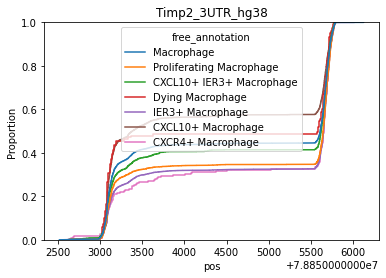

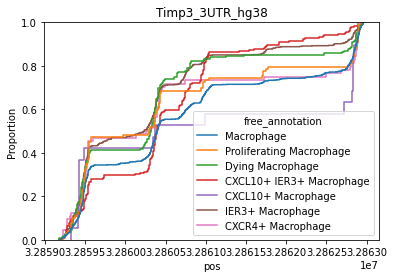

In [20]:
for gene,plot_df in macrophage_df.groupby('gene'):
    sns.ecdfplot(
        x = 'pos',
        hue = 'free_annotation',
        data = plot_df,
    )
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(gene)
    plt.show()
    plt.close()

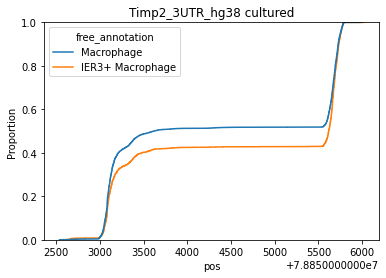

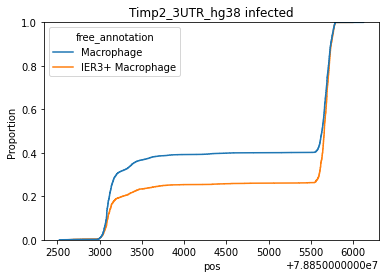

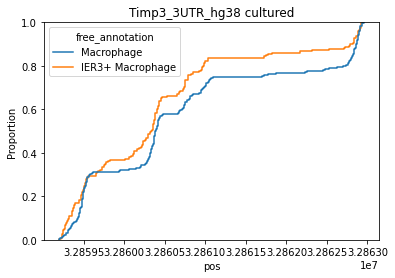

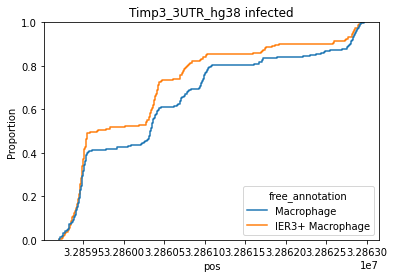

In [34]:
macrophage_subtypes = {'Macrophage', 'IER3+ Macrophage'}
macrophage_sub_df = macrophage_df[macrophage_df['free_annotation'].isin(macrophage_subtypes)]
for (gene,infection),plot_df in macrophage_sub_df.groupby(['gene','infection']):
    if infection == 'noncultured':
        continue
    
    sns.ecdfplot(
        x = 'pos',
        hue = 'free_annotation',
        data = plot_df,
    )
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('{} {}'.format(gene,infection))
    plt.show()
    plt.close()

In [39]:
df

,gene,f_name,infection,culture_time,compartment,free_annotation,pos
0,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852516
1,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852526
2,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852526
3,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852530
4,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852568
...,...,...,...,...,...,...,...
401710,Timp3_3UTR_hg38,96h_infected_Sample_2_S10,infected,96,Endothelial,Lymphatic,32862961
401711,Timp3_3UTR_hg38,96h_infected_Sample_2_S10,infected,96,Endothelial,Lymphatic,32862961
401714,Timp3_3UTR_hg38,96h_infected_Sample_2_S10,infected,96,Epithelial,Alveolar Epithelial Type 2,32862963
401715,Timp3_3UTR_hg38,96h_infected_Sample_2_S10,infected,96,Immune,Macrophage,32862963


In [38]:
bedGraph_df

,gene,f_name,infection,culture_time,compartment,free_annotation,pos,bin


In [62]:
bedGraph_df

,gene,f_name,infection,culture_time,compartment,free_annotation,pos,count,chr,bin
0,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852516,1,chr11,NaN
1,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852526,1,chr11,NaN
2,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852526,1,chr11,NaN
3,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852530,1,chr11,NaN
4,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852568,1,chr11,NaN
...,...,...,...,...,...,...,...,...,...,...
386563,Timp2_3UTR_hg38,96h_infected_Sample_2_S10,infected,96,Immune,Macrophage,78855791,1,chr11,NaN
386564,Timp2_3UTR_hg38,96h_infected_Sample_2_S10,infected,96,Immune,Macrophage,78855791,1,chr11,NaN
386568,Timp2_3UTR_hg38,96h_infected_Sample_2_S10,infected,96,Immune,Macrophage,78855791,1,chr11,NaN
386573,Timp2_3UTR_hg38,96h_infected_Sample_2_S10,infected,96,Immune,Macrophage,78855885,1,chr11,NaN


In [65]:
bedGraph_df = df[
    df['gene'].eq('{}_3UTR_hg38'.format(gene)) &
    df['free_annotation'].isin(macrophage_subtypes)
].copy()

In [69]:
bins

array([118300841, 118300851, 118300861, 118300871, 118300881, 118300891,
       118300901, 118300911, 118300921, 118300931, 118300941, 118300951,
       118300961, 118300971, 118300981, 118300991, 118301001, 118301011,
       118301021, 118301031, 118301041, 118301051, 118301061, 118301071,
       118301081, 118301091, 118301101, 118301111, 118301121, 118301131,
       118301141, 118301151, 118301161, 118301171, 118301181, 118301191,
       118301201, 118301211, 118301221, 118301231, 118301241, 118301251,
       118301261, 118301271, 118301281, 118301291, 118301301, 118301311,
       118301321, 118301331, 118301341, 118301351, 118301361, 118301371,
       118301381, 118301391, 118301401, 118301411, 118301421, 118301431,
       118301441, 118301451, 118301461, 118301471, 118301481, 118301491,
       118301501, 118301511, 118301521, 118301531, 118301541, 118301551,
       118301561, 118301571, 118301581, 118301591, 118301601, 118301611,
       118301621, 118301631, 118301641, 118301651, 

In [73]:
pd.cut(bedGraph_df['pos'], bins=bins)

TypeError: cut() missing 1 required positional argument: 'bins'

In [71]:
bedGraph_df['pos']

0         78852516
1         78852526
2         78852526
3         78852530
4         78852568
            ...   
386563    78855791
386564    78855791
386568    78855791
386573    78855885
386574    78855933
Name: pos, Length: 131453, dtype: int64

In [75]:
df

,gene,f_name,infection,culture_time,compartment,free_annotation,pos
0,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852516
1,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852526
2,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852526
3,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852530
4,Timp2_3UTR_hg38,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852568
...,...,...,...,...,...,...,...
401710,Timp3_3UTR_hg38,96h_infected_Sample_2_S10,infected,96,Endothelial,Lymphatic,32862961
401711,Timp3_3UTR_hg38,96h_infected_Sample_2_S10,infected,96,Endothelial,Lymphatic,32862961
401714,Timp3_3UTR_hg38,96h_infected_Sample_2_S10,infected,96,Epithelial,Alveolar Epithelial Type 2,32862963
401715,Timp3_3UTR_hg38,96h_infected_Sample_2_S10,infected,96,Immune,Macrophage,32862963


In [89]:
bin_size = 10
macrophage_subtypes = {'Macrophage', 'IER3+ Macrophage'}


gene = 'Timp2'

#human coordinates
if gene == 'Timp3':
    chrom = 'chr22'
    min_val = 32859048
    max_val = 32863111
elif gene == 'Timp2':
    chrom = 'chr17'
    min_val = 78852917
    max_val = 78855885
else:
    print('Gene not known!')
    
    
bedGraph_df = df[
    df['gene'].eq('{}_3UTR_hg38'.format(gene)) &
    df['free_annotation'].isin(macrophage_subtypes)
].copy()

bedGraph_df['count'] = 1
bedGraph_df['chr'] = chrom

bedGraph_df.loc[bedGraph_df['infection'].eq('noncultured'), 'infection'] = 'cultured'

bins = np.arange(min_val,max_val,bin_size)
bin_labels = pd.Categorical(bins[:-1])

bedGraph_df['bin'] = pd.cut(bedGraph_df['pos'], bins=bins)

for infection,infection_g in bedGraph_df.groupby('infection'):

    num_onts = infection_g['free_annotation'].nunique()
    colors = sns.color_palette('viridis',num_onts)
    
    for i,(ont,g) in enumerate(infection_g.groupby('free_annotation')):
        ont = ont.replace('+','')
        
        red,green,blue = colors[i]
        red,green,blue = int(256*red),int(256*green),int(256*blue)

        tot_counts = g['count'].sum()

        bin_counts = g.groupby(['chr','bin'])['count'].sum().fillna(0)
        norm_bin_counts = bin_counts/bin_counts.max()
        cs_counts = bin_counts.cumsum()/tot_counts

        #Write out the cumulative table
        cs_out_path = '{}_{}_{}.bedGraph'.format(gene,infection,ont).replace(' ','_')
        
        with open(cs_out_path,'w') as f_out:
            f_out.write('browser position {}:{}-{}\n'.format(chrom,min_val,max_val))
            f_out.write('track type=bedGraph name="cs {} {}" visibility=hide maxHeightPixels=50 graphType=points color={},{},{} visibility=hide\n'.format(infection, ont,red,green,blue))

        cs_df = cs_counts.reset_index()
        cs_df['left'] = cs_df['bin'].apply(lambda v: v.left)
        cs_df['right'] = cs_df['bin'].apply(lambda v: v.right)
        cs_df[['chr','left','right','count']].to_csv(cs_out_path, mode='a', header=None, sep=' ', index=None)

        #Write out the density table
        density_out_path = 'density_{}_{}_{}.bedGraph'.format(gene,infection,ont).replace(' ','_')

        with open(density_out_path,'w') as f_out:
            f_out.write('browser position {}:{}-{}\n'.format(chrom,min_val,max_val))
            f_out.write('track type=bedGraph name="{} {}" visibility=full maxHeightPixels=50 graphType=points color={},{},{} visibility=hide\n'.format(infection, ont,red,green,blue))

        density_df = norm_bin_counts.reset_index()
        density_df['left'] = density_df['bin'].apply(lambda v: v.left)
        density_df['right'] = density_df['bin'].apply(lambda v: v.right)
        density_df[['chr','left','right','count']].to_csv(density_out_path, mode='a', header=None, sep=' ', index=None)
        